In [1]:
# Load brain data and mask

# Access nifti, bval & bvec files
from os.path import expanduser, join
home = expanduser('~')
dname = join(home, 'brain-data-neil')

fdwi = join(dname, 'cdmri11_r.nii')
mask = join(dname, 'vol0083_brain_mask.nii.gz')
fbval = join(dname, 'parameters_new_bval.txt')
fbvec = join(dname, 'parameters_new_bvec2.txt')

# Load dMRI datasets 
from dipy.io.image import load_nifti
data, affine, img = load_nifti(fdwi, return_img=True)
mask_data, affine1, img1 = load_nifti(mask, return_img=True)

# Check size of data --> (77, 92, 56, 1344)
print(data.shape)

(77, 92, 56, 1344)


In [2]:
# Set up acquisition scheme using bval, bvec

# Import relevant modules
from dmipy.core import modeling_framework
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from os.path import join
import numpy as np

# Load parameters and convert to SI units
bvalues = np.loadtxt(join('parameters_new_bval.txt'))  # given in s/m^2
bvalues_SI = bvalues * 1e6 # now given in SI units as s/mm^2
gradient_directions = np.loadtxt(join('parameters_new_bvec.txt'))

# delta and Delta times in seconds
delta = 0.0242
Delta = 0.0391

# Acquisition scheme
acq_scheme = acquisition_scheme_from_bvalues(bvalues_SI, gradient_directions, delta, Delta)
acq_scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 1344
number of b0 measurements: 84
number of DWI shells: 4

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |84        |0               |0                        |24.2       |39.1      |N/A  
1           |84        |500             |19                       |24.2       |39.1      |N/A  
2           |252       |1000            |27                       |24.2       |39.1      |N/A  
3           |420       |2000            |39                       |24.2       |39.1      |N/A  
4           |504       |3000            |48                       |24.2       |39.1      |N/A  


In [3]:
# Create ball & stick model

from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
BAS = MultiCompartmentModel(models=[stick, ball])
# BAS.set_parameter_optimization_bounds('C1Stick_1_lambda_par', [0.5e-9, 4e-9])
# BAS.set_fixed_parameter('C1Stick_1_lambda_par', 2e-9)
print(BAS.parameter_cardinality)

OrderedDict([('C1Stick_1_mu', 2), ('C1Stick_1_lambda_par', 1), ('G1Ball_1_lambda_iso', 1), ('partial_volume_0', 1), ('partial_volume_1', 1)])


In [5]:
BAS_fit = BAS.fit(acq_scheme, data, mask=mask_data)

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3884060382843018 seconds
Fitting of 89297 voxels complete in 2207.2728140354156 seconds.
Average of 0.02471833112014307 seconds per voxel.


TypeError: Invalid shape (77, 92, 56, 2) for image data

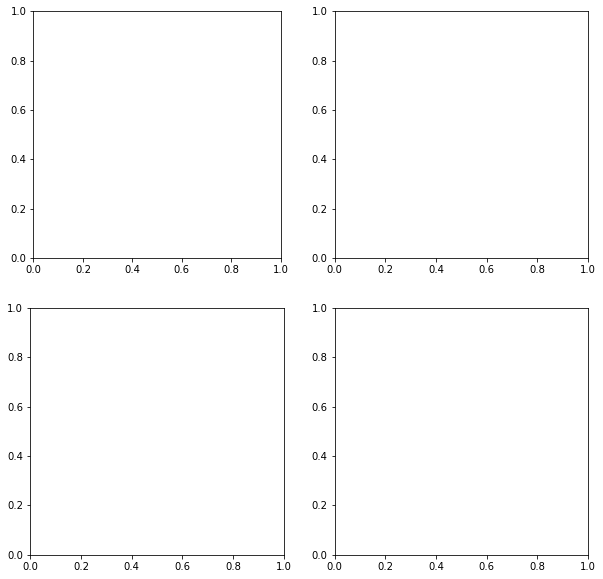

In [8]:
import matplotlib.pyplot as plt

fitted_parameters = BAS_fit.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
#     if values.squeeze().ndim != 2:
#         continue
    cf = axs[counter].imshow(values)
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.8)
    counter += 1

In [ ]:
# TEST: Test run with mu parameter and first 30 voxels
import numpy as np

# print(data.shape[0:2], 2)
mu = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, 30):
    for y in range(0, 30):
        if mask_data[x,y,30] > 0:
            fitted_BAS = BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['C1Stick_1_mu'])
            mu[x,y,:] = fitted_BAS.fitted_parameters['C1Stick_1_mu']
            print((x, y))
            
print(mu)

In [ ]:
# TEST: Visualise the test (will only see some voxels in top left)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(mu[:,:,1])

In [ ]:
# PARAMETER C1Stick_1_mu
import numpy as np

mu = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_BAS = BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['C1Stick_1_mu'])
            mu[x,y,:] = fitted_BAS.fitted_parameters['C1Stick_1_mu']
            print((x, y))
            
print(mu)

In [ ]:
# Save mu as a nifti file to view on FSLeyes
from dipy.io.image import save_nifti
save_nifti('BAS_stick_mu.nii.gz', mu, affine)

In [ ]:
# Visualise mu
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(mu[:,:,0])
ax2.imshow(mu[:,:,1])
ax1.set_title('C1Stick_1_mu')
ax2.set_title('C1Stick_1_mu')

In [ ]:
# PARAMETER C1Stick_1_lambda_par
import numpy as np

lpar = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_BAS = BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['C1Stick_1_lambda_par'])
            lpar[x,y,:] = fitted_BAS.fitted_parameters['C1Stick_1_lambda_par']
            print((x, y))
            
print(lpar)

In [ ]:
# Save lambda_par as a nifti file to view on FSLeyes
from dipy.io.image import save_nifti
save_nifti('BAS_stick_lambda_par.nii.gz', lpar, affine)

In [ ]:
# Visualise lambda_par
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(lpar[:,:,0])
ax2.imshow(lpar[:,:,1])
ax1.set_title('C1Stick_1_lambda_par')
ax2.set_title('C1Stick_1_lambda_par')

In [4]:
# PARAMETER G1Ball_1_lambda_iso
import numpy as np

l_iso = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_BAS = BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['G1Ball_1_lambda_iso'])
            l_iso[x,y,:] = fitted_BAS.fitted_parameters['G1Ball_1_lambda_iso']
            print((x, y))
            
print(l_iso)

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2473578453063965 seconds
Fitting of 1 voxels complete in 1.4909589290618896 seconds.
Average of 1.4909589290618896 seconds per voxel.
[1.43855593e-09]
(14, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3821980953216553 seconds
Fitting of 1 voxels complete in 0.0815742015838623 seconds.
Average of 0.0815742015838623 seconds per voxel.
[1.70550179e-09]
(14, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4032588005065918 seconds
Fitting of 1 voxels complete in 0.058322906494140625 seconds.
Average of 0.058322906494140625 seconds per voxel.
[1.89415828e-09]
(14, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3968219757080078 seconds
Fitting of 1 voxels complete in 0.10060715675354004 seconds.
Average of 0.10060715675354004 seconds per voxel.
[1.76273772e-09]
(14, 37)
Using parallel processing with 4 workers.
Setup brute2fine

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3915839195251465 seconds
Fitting of 1 voxels complete in 0.08507013320922852 seconds.
Average of 0.08507013320922852 seconds per voxel.
[9.45467329e-10]
(16, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41575121879577637 seconds
Fitting of 1 voxels complete in 0.07979416847229004 seconds.
Average of 0.07979416847229004 seconds per voxel.
[9.46598728e-10]
(16, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5395479202270508 seconds
Fitting of 1 voxels complete in 0.09444093704223633 seconds.
Average of 0.09444093704223633 seconds per voxel.
[9.96291544e-10]
(16, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40382909774780273 seconds
Fitting of 1 voxels complete in 0.07377219200134277 seconds.
Average of 0.07377219200134277 seconds per voxel.
[1.42993806e-09]
(16, 40)
Using parallel processing with 4 workers.
Setup brute2

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.49111294746398926 seconds
Fitting of 1 voxels complete in 0.10360908508300781 seconds.
Average of 0.10360908508300781 seconds per voxel.
[1.31247678e-09]
(17, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42090797424316406 seconds
Fitting of 1 voxels complete in 0.09533309936523438 seconds.
Average of 0.09533309936523438 seconds per voxel.
[1.56837995e-09]
(17, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4405629634857178 seconds
Fitting of 1 voxels complete in 0.06969070434570312 seconds.
Average of 0.06969070434570312 seconds per voxel.
[1.47565222e-09]
(18, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38158607482910156 seconds
Fitting of 1 voxels complete in 0.07667398452758789 seconds.
Average of 0.07667398452758789 seconds per voxel.
[9.78630987e-10]
(18, 22)
Using parallel processing with 4 workers.
Setup brute

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5457239151000977 seconds
Fitting of 1 voxels complete in 0.08793807029724121 seconds.
Average of 0.08793807029724121 seconds per voxel.
[2.65725476e-09]
(18, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38118791580200195 seconds
Fitting of 1 voxels complete in 0.1628589630126953 seconds.
Average of 0.1628589630126953 seconds per voxel.
[1.09083301e-09]
(18, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.442885160446167 seconds
Fitting of 1 voxels complete in 0.07474040985107422 seconds.
Average of 0.07474040985107422 seconds per voxel.
[1.31582022e-09]
(19, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3749837875366211 seconds
Fitting of 1 voxels complete in 0.06811714172363281 seconds.
Average of 0.06811714172363281 seconds per voxel.
[1.17402995e-09]
(19, 21)
Using parallel processing with 4 workers.
Setup brute2fine

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4125518798828125 seconds
Fitting of 1 voxels complete in 0.04756784439086914 seconds.
Average of 0.04756784439086914 seconds per voxel.
[3.e-09]
(19, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5415658950805664 seconds
Fitting of 1 voxels complete in 0.0713200569152832 seconds.
Average of 0.0713200569152832 seconds per voxel.
[2.94741377e-09]
(19, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5173168182373047 seconds
Fitting of 1 voxels complete in 0.08806610107421875 seconds.
Average of 0.08806610107421875 seconds per voxel.
[1.76959027e-09]
(19, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4274289608001709 seconds
Fitting of 1 voxels complete in 0.1175680160522461 seconds.
Average of 0.1175680160522461 seconds per voxel.
[1.63324247e-09]
(19, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4932548999786377 seconds
Fitting of 1 voxels complete in 0.07561135292053223 seconds.
Average of 0.07561135292053223 seconds per voxel.
[9.73134742e-10]
(20, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37877511978149414 seconds
Fitting of 1 voxels complete in 0.07838678359985352 seconds.
Average of 0.07838678359985352 seconds per voxel.
[9.2169974e-10]
(20, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3910200595855713 seconds
Fitting of 1 voxels complete in 0.06400609016418457 seconds.
Average of 0.06400609016418457 seconds per voxel.
[7.48035312e-10]
(20, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36710619926452637 seconds
Fitting of 1 voxels complete in 0.06929612159729004 seconds.
Average of 0.06929612159729004 seconds per voxel.
[1.20186219e-09]
(20, 51)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.447368860244751 seconds
Fitting of 1 voxels complete in 0.08596205711364746 seconds.
Average of 0.08596205711364746 seconds per voxel.
[1.5623242e-09]
(21, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37532711029052734 seconds
Fitting of 1 voxels complete in 0.0686807632446289 seconds.
Average of 0.0686807632446289 seconds per voxel.
[9.65337313e-10]
(21, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44254088401794434 seconds
Fitting of 1 voxels complete in 0.10339188575744629 seconds.
Average of 0.10339188575744629 seconds per voxel.
[9.98358827e-10]
(21, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5115141868591309 seconds
Fitting of 1 voxels complete in 0.09833383560180664 seconds.
Average of 0.09833383560180664 seconds per voxel.
[1.09658242e-09]
(21, 42)
Using parallel processing with 4 workers.
Setup brute2fine

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3751339912414551 seconds
Fitting of 1 voxels complete in 0.07140493392944336 seconds.
Average of 0.07140493392944336 seconds per voxel.
[1.30436412e-09]
(22, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37296199798583984 seconds
Fitting of 1 voxels complete in 0.06619477272033691 seconds.
Average of 0.06619477272033691 seconds per voxel.
[9.90397523e-10]
(22, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37511491775512695 seconds
Fitting of 1 voxels complete in 0.06195497512817383 seconds.
Average of 0.06195497512817383 seconds per voxel.
[1.0380745e-09]
(22, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3741638660430908 seconds
Fitting of 1 voxels complete in 0.0632331371307373 seconds.
Average of 0.0632331371307373 seconds per voxel.
[1.09816714e-09]
(22, 29)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43439412117004395 seconds
Fitting of 1 voxels complete in 0.08481478691101074 seconds.
Average of 0.08481478691101074 seconds per voxel.
[9.33121759e-10]
(22, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3880281448364258 seconds
Fitting of 1 voxels complete in 0.07783985137939453 seconds.
Average of 0.07783985137939453 seconds per voxel.
[1.51219854e-09]
(22, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40972089767456055 seconds
Fitting of 1 voxels complete in 0.0726020336151123 seconds.
Average of 0.0726020336151123 seconds per voxel.
[1.99712903e-09]
(22, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.415938138961792 seconds
Fitting of 1 voxels complete in 0.06910395622253418 seconds.
Average of 0.06910395622253418 seconds per voxel.
[1.46209717e-09]
(22, 64)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.45746707916259766 seconds
Fitting of 1 voxels complete in 0.07651400566101074 seconds.
Average of 0.07651400566101074 seconds per voxel.
[9.0814114e-10]
(23, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38369297981262207 seconds
Fitting of 1 voxels complete in 0.0695030689239502 seconds.
Average of 0.0695030689239502 seconds per voxel.
[9.91449385e-10]
(23, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4692568778991699 seconds
Fitting of 1 voxels complete in 0.05660200119018555 seconds.
Average of 0.05660200119018555 seconds per voxel.
[1.14975524e-09]
(23, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3728218078613281 seconds
Fitting of 1 voxels complete in 0.06061410903930664 seconds.
Average of 0.06061410903930664 seconds per voxel.
[1.07331292e-09]
(23, 49)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41528987884521484 seconds
Fitting of 1 voxels complete in 0.09778165817260742 seconds.
Average of 0.09778165817260742 seconds per voxel.
[1.06234251e-09]
(24, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44278597831726074 seconds
Fitting of 1 voxels complete in 0.06722426414489746 seconds.
Average of 0.06722426414489746 seconds per voxel.
[1.07802067e-09]
(24, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38817906379699707 seconds
Fitting of 1 voxels complete in 0.07401108741760254 seconds.
Average of 0.07401108741760254 seconds per voxel.
[8.85635355e-10]
(24, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40460896492004395 seconds
Fitting of 1 voxels complete in 0.07322287559509277 seconds.
Average of 0.07322287559509277 seconds per voxel.
[1.01272858e-09]
(24, 31)
Using parallel processing with 4 workers.
Setup brut

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4528799057006836 seconds
Fitting of 1 voxels complete in 0.07842183113098145 seconds.
Average of 0.07842183113098145 seconds per voxel.
[9.37333317e-10]
(24, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39191770553588867 seconds
Fitting of 1 voxels complete in 0.10836505889892578 seconds.
Average of 0.10836505889892578 seconds per voxel.
[9.12294696e-10]
(24, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4008021354675293 seconds
Fitting of 1 voxels complete in 0.07534098625183105 seconds.
Average of 0.07534098625183105 seconds per voxel.
[1.00575238e-09]
(24, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3921229839324951 seconds
Fitting of 1 voxels complete in 0.07155394554138184 seconds.
Average of 0.07155394554138184 seconds per voxel.
[1.68303471e-09]
(24, 66)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3774149417877197 seconds
Fitting of 1 voxels complete in 0.07098913192749023 seconds.
Average of 0.07098913192749023 seconds per voxel.
[9.76892198e-10]
(25, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37517499923706055 seconds
Fitting of 1 voxels complete in 0.06496286392211914 seconds.
Average of 0.06496286392211914 seconds per voxel.
[9.33686807e-10]
(25, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37438392639160156 seconds
Fitting of 1 voxels complete in 0.06566333770751953 seconds.
Average of 0.06566333770751953 seconds per voxel.
[9.43530239e-10]
(25, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37200403213500977 seconds
Fitting of 1 voxels complete in 0.07003378868103027 seconds.
Average of 0.07003378868103027 seconds per voxel.
[1.12775305e-09]
(25, 44)
Using parallel processing with 4 workers.
Setup brute

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.46557021141052246 seconds
Fitting of 1 voxels complete in 0.08664608001708984 seconds.
Average of 0.08664608001708984 seconds per voxel.
[8.95975128e-10]
(26, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41796135902404785 seconds
Fitting of 1 voxels complete in 0.07733511924743652 seconds.
Average of 0.07733511924743652 seconds per voxel.
[9.80574873e-10]
(26, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3750462532043457 seconds
Fitting of 1 voxels complete in 0.07394289970397949 seconds.
Average of 0.07394289970397949 seconds per voxel.
[1.15132503e-09]
(26, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3749980926513672 seconds
Fitting of 1 voxels complete in 0.06081891059875488 seconds.
Average of 0.06081891059875488 seconds per voxel.
[1.05605269e-09]
(26, 21)
Using parallel processing with 4 workers.
Setup brute2

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5861098766326904 seconds
Fitting of 1 voxels complete in 0.10368990898132324 seconds.
Average of 0.10368990898132324 seconds per voxel.
[1.31589331e-09]
(26, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5460150241851807 seconds
Fitting of 1 voxels complete in 0.05759596824645996 seconds.
Average of 0.05759596824645996 seconds per voxel.
[1.70330693e-09]
(26, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.6022169589996338 seconds
Fitting of 1 voxels complete in 0.09944891929626465 seconds.
Average of 0.09944891929626465 seconds per voxel.
[1.01535352e-09]
(26, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.470383882522583 seconds
Fitting of 1 voxels complete in 0.06805181503295898 seconds.
Average of 0.06805181503295898 seconds per voxel.
[9.29161551e-10]
(26, 56)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.45949482917785645 seconds
Fitting of 1 voxels complete in 0.06461477279663086 seconds.
Average of 0.06461477279663086 seconds per voxel.
[1.08038189e-09]
(27, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.45029282569885254 seconds
Fitting of 1 voxels complete in 0.059471845626831055 seconds.
Average of 0.059471845626831055 seconds per voxel.
[1.12226223e-09]
(27, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4905521869659424 seconds
Fitting of 1 voxels complete in 0.08684420585632324 seconds.
Average of 0.08684420585632324 seconds per voxel.
[1.10373099e-09]
(27, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5242249965667725 seconds
Fitting of 1 voxels complete in 0.08331990242004395 seconds.
Average of 0.08331990242004395 seconds per voxel.
[1.08690984e-09]
(27, 32)
Using parallel processing with 4 workers.
Setup brut

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4076962471008301 seconds
Fitting of 1 voxels complete in 0.07977128028869629 seconds.
Average of 0.07977128028869629 seconds per voxel.
[9.4581466e-10]
(27, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3754410743713379 seconds
Fitting of 1 voxels complete in 0.059797048568725586 seconds.
Average of 0.059797048568725586 seconds per voxel.
[1.15828158e-09]
(27, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37569689750671387 seconds
Fitting of 1 voxels complete in 0.07527303695678711 seconds.
Average of 0.07527303695678711 seconds per voxel.
[1.30171571e-09]
(27, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3743910789489746 seconds
Fitting of 1 voxels complete in 0.08254289627075195 seconds.
Average of 0.08254289627075195 seconds per voxel.
[1.12069831e-09]
(27, 67)
Using parallel processing with 4 workers.
Setup brute2

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41117405891418457 seconds
Fitting of 1 voxels complete in 0.07971405982971191 seconds.
Average of 0.07971405982971191 seconds per voxel.
[9.07086833e-10]
(28, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.400223970413208 seconds
Fitting of 1 voxels complete in 0.06131124496459961 seconds.
Average of 0.06131124496459961 seconds per voxel.
[9.5682848e-10]
(28, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3701338768005371 seconds
Fitting of 1 voxels complete in 0.06537890434265137 seconds.
Average of 0.06537890434265137 seconds per voxel.
[8.97224306e-10]
(28, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3757362365722656 seconds
Fitting of 1 voxels complete in 0.0715179443359375 seconds.
Average of 0.0715179443359375 seconds per voxel.
[8.92515774e-10]
(28, 42)
Using parallel processing with 4 workers.
Setup brute2fine 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3752140998840332 seconds
Fitting of 1 voxels complete in 0.06475090980529785 seconds.
Average of 0.06475090980529785 seconds per voxel.
[9.27892515e-10]
(29, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.374514102935791 seconds
Fitting of 1 voxels complete in 0.08252191543579102 seconds.
Average of 0.08252191543579102 seconds per voxel.
[8.33064982e-10]
(29, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40064072608947754 seconds
Fitting of 1 voxels complete in 0.1032860279083252 seconds.
Average of 0.1032860279083252 seconds per voxel.
[8.86690386e-10]
(29, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41629600524902344 seconds
Fitting of 1 voxels complete in 0.07017087936401367 seconds.
Average of 0.07017087936401367 seconds per voxel.
[1.06119668e-09]
(29, 16)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4138009548187256 seconds
Fitting of 1 voxels complete in 0.09045195579528809 seconds.
Average of 0.09045195579528809 seconds per voxel.
[9.33120091e-10]
(29, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4432950019836426 seconds
Fitting of 1 voxels complete in 0.10513925552368164 seconds.
Average of 0.10513925552368164 seconds per voxel.
[8.85136989e-10]
(29, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43412017822265625 seconds
Fitting of 1 voxels complete in 0.0684199333190918 seconds.
Average of 0.0684199333190918 seconds per voxel.
[8.6472183e-10]
(29, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3758201599121094 seconds
Fitting of 1 voxels complete in 0.07934880256652832 seconds.
Average of 0.07934880256652832 seconds per voxel.
[8.46089716e-10]
(29, 51)
Using parallel processing with 4 workers.
Setup brute2fine

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38260793685913086 seconds
Fitting of 1 voxels complete in 0.07523608207702637 seconds.
Average of 0.07523608207702637 seconds per voxel.
[9.84296401e-10]
(30, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3967108726501465 seconds
Fitting of 1 voxels complete in 0.0692758560180664 seconds.
Average of 0.0692758560180664 seconds per voxel.
[1.09783739e-09]
(30, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3944072723388672 seconds
Fitting of 1 voxels complete in 0.07506084442138672 seconds.
Average of 0.07506084442138672 seconds per voxel.
[1.08248912e-09]
(30, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3818838596343994 seconds
Fitting of 1 voxels complete in 0.06694316864013672 seconds.
Average of 0.06694316864013672 seconds per voxel.
[1.10254362e-09]
(30, 24)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37027907371520996 seconds
Fitting of 1 voxels complete in 0.06705808639526367 seconds.
Average of 0.06705808639526367 seconds per voxel.
[1.55997946e-09]
(30, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37085700035095215 seconds
Fitting of 1 voxels complete in 0.06412005424499512 seconds.
Average of 0.06412005424499512 seconds per voxel.
[1.18541337e-09]
(30, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3700888156890869 seconds
Fitting of 1 voxels complete in 0.06861686706542969 seconds.
Average of 0.06861686706542969 seconds per voxel.
[9.99641938e-10]
(30, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37090086936950684 seconds
Fitting of 1 voxels complete in 0.0641639232635498 seconds.
Average of 0.0641639232635498 seconds per voxel.
[1.00727787e-09]
(30, 59)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4223339557647705 seconds
Fitting of 1 voxels complete in 0.08025074005126953 seconds.
Average of 0.08025074005126953 seconds per voxel.
[1.17845257e-09]
(31, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.392899751663208 seconds
Fitting of 1 voxels complete in 0.07214784622192383 seconds.
Average of 0.07214784622192383 seconds per voxel.
[1.17806387e-09]
(31, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.371920108795166 seconds
Fitting of 1 voxels complete in 0.06227707862854004 seconds.
Average of 0.06227707862854004 seconds per voxel.
[1.23103713e-09]
(31, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3728611469268799 seconds
Fitting of 1 voxels complete in 0.05902600288391113 seconds.
Average of 0.05902600288391113 seconds per voxel.
[1.27895036e-09]
(31, 30)
Using parallel processing with 4 workers.
Setup brute2fine

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37750887870788574 seconds
Fitting of 1 voxels complete in 0.06212592124938965 seconds.
Average of 0.06212592124938965 seconds per voxel.
[1.02291081e-09]
(31, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3860161304473877 seconds
Fitting of 1 voxels complete in 0.07110905647277832 seconds.
Average of 0.07110905647277832 seconds per voxel.
[1.0044215e-09]
(31, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38596200942993164 seconds
Fitting of 1 voxels complete in 0.06361103057861328 seconds.
Average of 0.06361103057861328 seconds per voxel.
[8.30520276e-10]
(31, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3766810894012451 seconds
Fitting of 1 voxels complete in 0.06349682807922363 seconds.
Average of 0.06349682807922363 seconds per voxel.
[9.29850737e-10]
(31, 65)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3779640197753906 seconds
Fitting of 1 voxels complete in 0.0559537410736084 seconds.
Average of 0.0559537410736084 seconds per voxel.
[3.e-09]
(32, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38402700424194336 seconds
Fitting of 1 voxels complete in 0.07433485984802246 seconds.
Average of 0.07433485984802246 seconds per voxel.
[2.95197142e-09]
(32, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38529515266418457 seconds
Fitting of 1 voxels complete in 0.057297706604003906 seconds.
Average of 0.057297706604003906 seconds per voxel.
[1.54387069e-09]
(32, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3773989677429199 seconds
Fitting of 1 voxels complete in 0.05965685844421387 seconds.
Average of 0.05965685844421387 seconds per voxel.
[1.13183111e-09]
(32, 36)
Using parallel processing with 4 workers.
Setup brute2fine opt

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3763101100921631 seconds
Fitting of 1 voxels complete in 0.07205319404602051 seconds.
Average of 0.07205319404602051 seconds per voxel.
[9.87856733e-10]
(32, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3747420310974121 seconds
Fitting of 1 voxels complete in 0.06096696853637695 seconds.
Average of 0.06096696853637695 seconds per voxel.
[9.23933624e-10]
(32, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.377673864364624 seconds
Fitting of 1 voxels complete in 0.06895995140075684 seconds.
Average of 0.06895995140075684 seconds per voxel.
[1.06092777e-09]
(32, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3757822513580322 seconds
Fitting of 1 voxels complete in 0.06629204750061035 seconds.
Average of 0.06629204750061035 seconds per voxel.
[1.18033936e-09]
(32, 71)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3791170120239258 seconds
Fitting of 1 voxels complete in 0.07002401351928711 seconds.
Average of 0.07002401351928711 seconds per voxel.
[9.71918442e-10]
(33, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3731069564819336 seconds
Fitting of 1 voxels complete in 0.06650614738464355 seconds.
Average of 0.06650614738464355 seconds per voxel.
[1.01662851e-09]
(33, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3833589553833008 seconds
Fitting of 1 voxels complete in 0.058550119400024414 seconds.
Average of 0.058550119400024414 seconds per voxel.
[9.81954252e-10]
(33, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38114404678344727 seconds
Fitting of 1 voxels complete in 0.06537604331970215 seconds.
Average of 0.06537604331970215 seconds per voxel.
[1.01538685e-09]
(33, 40)
Using parallel processing with 4 workers.
Setup brute

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37555408477783203 seconds
Fitting of 1 voxels complete in 0.06171703338623047 seconds.
Average of 0.06171703338623047 seconds per voxel.
[9.65958769e-10]
(33, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37616586685180664 seconds
Fitting of 1 voxels complete in 0.061058759689331055 seconds.
Average of 0.061058759689331055 seconds per voxel.
[1.89513037e-09]
(33, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4066777229309082 seconds
Fitting of 1 voxels complete in 0.052269697189331055 seconds.
Average of 0.052269697189331055 seconds per voxel.
[3.e-09]
(33, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37796926498413086 seconds
Fitting of 1 voxels complete in 0.0781092643737793 seconds.
Average of 0.0781092643737793 seconds per voxel.
[1.47744249e-09]
(34, 9)
Using parallel processing with 4 workers.
Setup brute2fine o

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3742220401763916 seconds
Fitting of 1 voxels complete in 0.07347297668457031 seconds.
Average of 0.07347297668457031 seconds per voxel.
[1.02779771e-09]
(34, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3760242462158203 seconds
Fitting of 1 voxels complete in 0.061222076416015625 seconds.
Average of 0.061222076416015625 seconds per voxel.
[1.10186923e-09]
(34, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37511515617370605 seconds
Fitting of 1 voxels complete in 0.05421185493469238 seconds.
Average of 0.05421185493469238 seconds per voxel.
[1.08585443e-09]
(34, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3753347396850586 seconds
Fitting of 1 voxels complete in 0.060376882553100586 seconds.
Average of 0.060376882553100586 seconds per voxel.
[1.0618491e-09]
(34, 44)
Using parallel processing with 4 workers.
Setup brut

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37484169006347656 seconds
Fitting of 1 voxels complete in 0.06455397605895996 seconds.
Average of 0.06455397605895996 seconds per voxel.
[1.12584998e-09]
(35, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3733088970184326 seconds
Fitting of 1 voxels complete in 0.06868720054626465 seconds.
Average of 0.06868720054626465 seconds per voxel.
[1.33013527e-09]
(35, 12)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37755680084228516 seconds
Fitting of 1 voxels complete in 0.08134984970092773 seconds.
Average of 0.08134984970092773 seconds per voxel.
[2.01677505e-09]
(35, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3744170665740967 seconds
Fitting of 1 voxels complete in 0.054654836654663086 seconds.
Average of 0.054654836654663086 seconds per voxel.
[1.62302716e-09]
(35, 14)
Using parallel processing with 4 workers.
Setup brut

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3739640712738037 seconds
Fitting of 1 voxels complete in 0.05649518966674805 seconds.
Average of 0.05649518966674805 seconds per voxel.
[1.08263165e-09]
(35, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3724668025970459 seconds
Fitting of 1 voxels complete in 0.07049393653869629 seconds.
Average of 0.07049393653869629 seconds per voxel.
[6.37576196e-10]
(35, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3759329319000244 seconds
Fitting of 1 voxels complete in 0.06800103187561035 seconds.
Average of 0.06800103187561035 seconds per voxel.
[6.32390866e-10]
(35, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37644100189208984 seconds
Fitting of 1 voxels complete in 0.04746699333190918 seconds.
Average of 0.04746699333190918 seconds per voxel.
[7.25007768e-10]
(35, 49)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37206602096557617 seconds
Fitting of 1 voxels complete in 0.06338191032409668 seconds.
Average of 0.06338191032409668 seconds per voxel.
[1.47458196e-09]
(36, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37186193466186523 seconds
Fitting of 1 voxels complete in 0.05387115478515625 seconds.
Average of 0.05387115478515625 seconds per voxel.
[1.60837366e-09]
(36, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3728210926055908 seconds
Fitting of 1 voxels complete in 0.0700836181640625 seconds.
Average of 0.0700836181640625 seconds per voxel.
[1.18986225e-09]
(36, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3731210231781006 seconds
Fitting of 1 voxels complete in 0.061018943786621094 seconds.
Average of 0.061018943786621094 seconds per voxel.
[8.49442828e-10]
(36, 19)
Using parallel processing with 4 workers.
Setup brute2

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3764159679412842 seconds
Fitting of 1 voxels complete in 0.06088614463806152 seconds.
Average of 0.06088614463806152 seconds per voxel.
[9.96365272e-10]
(36, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37108397483825684 seconds
Fitting of 1 voxels complete in 0.06599807739257812 seconds.
Average of 0.06599807739257812 seconds per voxel.
[9.38265685e-10]
(36, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37371110916137695 seconds
Fitting of 1 voxels complete in 0.06554484367370605 seconds.
Average of 0.06554484367370605 seconds per voxel.
[8.98653415e-10]
(36, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3753201961517334 seconds
Fitting of 1 voxels complete in 0.05885004997253418 seconds.
Average of 0.05885004997253418 seconds per voxel.
[1.9876795e-09]
(36, 54)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5509743690490723 seconds
Fitting of 1 voxels complete in 0.12196493148803711 seconds.
Average of 0.12196493148803711 seconds per voxel.
[1.07102287e-09]
(37, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5474708080291748 seconds
Fitting of 1 voxels complete in 0.08416509628295898 seconds.
Average of 0.08416509628295898 seconds per voxel.
[1.5503789e-09]
(37, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5742602348327637 seconds
Fitting of 1 voxels complete in 0.09883999824523926 seconds.
Average of 0.09883999824523926 seconds per voxel.
[1.05214182e-09]
(37, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5983471870422363 seconds
Fitting of 1 voxels complete in 0.09817290306091309 seconds.
Average of 0.09817290306091309 seconds per voxel.
[9.49595922e-10]
(37, 25)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5188710689544678 seconds
Fitting of 1 voxels complete in 0.08430600166320801 seconds.
Average of 0.08430600166320801 seconds per voxel.
[2.6344036e-09]
(37, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43438720703125 seconds
Fitting of 1 voxels complete in 0.1032860279083252 seconds.
Average of 0.1032860279083252 seconds per voxel.
[9.94083618e-10]
(37, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.391970157623291 seconds
Fitting of 1 voxels complete in 0.05941033363342285 seconds.
Average of 0.05941033363342285 seconds per voxel.
[1.01646734e-09]
(37, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38712501525878906 seconds
Fitting of 1 voxels complete in 0.06831502914428711 seconds.
Average of 0.06831502914428711 seconds per voxel.
[1.17821324e-09]
(37, 60)
Using parallel processing with 4 workers.
Setup brute2fine op

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3698611259460449 seconds
Fitting of 1 voxels complete in 0.07405781745910645 seconds.
Average of 0.07405781745910645 seconds per voxel.
[8.99228728e-10]
(38, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37175488471984863 seconds
Fitting of 1 voxels complete in 0.07592177391052246 seconds.
Average of 0.07592177391052246 seconds per voxel.
[9.07213113e-10]
(38, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3715949058532715 seconds
Fitting of 1 voxels complete in 0.06373095512390137 seconds.
Average of 0.06373095512390137 seconds per voxel.
[8.50860548e-10]
(38, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3724820613861084 seconds
Fitting of 1 voxels complete in 0.06689310073852539 seconds.
Average of 0.06689310073852539 seconds per voxel.
[9.10019386e-10]
(38, 31)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3723759651184082 seconds
Fitting of 1 voxels complete in 0.05553007125854492 seconds.
Average of 0.05553007125854492 seconds per voxel.
[1.11633992e-09]
(38, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3779268264770508 seconds
Fitting of 1 voxels complete in 0.07087993621826172 seconds.
Average of 0.07087993621826172 seconds per voxel.
[1.21541235e-09]
(38, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37224292755126953 seconds
Fitting of 1 voxels complete in 0.06924605369567871 seconds.
Average of 0.06924605369567871 seconds per voxel.
[9.19181937e-10]
(38, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3700981140136719 seconds
Fitting of 1 voxels complete in 0.07033181190490723 seconds.
Average of 0.07033181190490723 seconds per voxel.
[9.58369273e-10]
(38, 66)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43535804748535156 seconds
Fitting of 1 voxels complete in 0.0596470832824707 seconds.
Average of 0.0596470832824707 seconds per voxel.
[1.77847867e-09]
(39, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5197241306304932 seconds
Fitting of 1 voxels complete in 0.14432191848754883 seconds.
Average of 0.14432191848754883 seconds per voxel.
[1.51092067e-09]
(39, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5496397018432617 seconds
Fitting of 1 voxels complete in 0.07311582565307617 seconds.
Average of 0.07311582565307617 seconds per voxel.
[1.41583537e-09]
(39, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3918118476867676 seconds
Fitting of 1 voxels complete in 0.07050704956054688 seconds.
Average of 0.07050704956054688 seconds per voxel.
[1.32758721e-09]
(39, 37)
Using parallel processing with 4 workers.
Setup brute2fin

Setup brute2fine optimizer in 0.3672761917114258 seconds
Fitting of 1 voxels complete in 0.06830716133117676 seconds.
Average of 0.06830716133117676 seconds per voxel.
[1.90586361e-09]
(39, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3714029788970947 seconds
Fitting of 1 voxels complete in 0.06589889526367188 seconds.
Average of 0.06589889526367188 seconds per voxel.
[2.66370722e-09]
(39, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3710899353027344 seconds
Fitting of 1 voxels complete in 0.06432509422302246 seconds.
Average of 0.06432509422302246 seconds per voxel.
[1.34331395e-09]
(39, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41707396507263184 seconds
Fitting of 1 voxels complete in 0.10483098030090332 seconds.
Average of 0.10483098030090332 seconds per voxel.
[1.35163179e-09]
(39, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44612717628479004 secon

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.589148759841919 seconds
Fitting of 1 voxels complete in 0.0838460922241211 seconds.
Average of 0.0838460922241211 seconds per voxel.
[1.83792558e-09]
(40, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.48821091651916504 seconds
Fitting of 1 voxels complete in 0.09135317802429199 seconds.
Average of 0.09135317802429199 seconds per voxel.
[1.4262637e-09]
(40, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4126150608062744 seconds
Fitting of 1 voxels complete in 0.09331417083740234 seconds.
Average of 0.09331417083740234 seconds per voxel.
[1.03631646e-09]
(40, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42882204055786133 seconds
Fitting of 1 voxels complete in 0.07264924049377441 seconds.
Average of 0.07264924049377441 seconds per voxel.
[1.05016248e-09]
(40, 44)
Using parallel processing with 4 workers.
Setup brute2fine

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42496323585510254 seconds
Fitting of 1 voxels complete in 0.07881808280944824 seconds.
Average of 0.07881808280944824 seconds per voxel.
[1.23359475e-09]
(41, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37420105934143066 seconds
Fitting of 1 voxels complete in 0.0706338882446289 seconds.
Average of 0.0706338882446289 seconds per voxel.
[9.28879587e-10]
(41, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39585280418395996 seconds
Fitting of 1 voxels complete in 0.07116174697875977 seconds.
Average of 0.07116174697875977 seconds per voxel.
[1.32618348e-09]
(41, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3761451244354248 seconds
Fitting of 1 voxels complete in 0.06405925750732422 seconds.
Average of 0.06405925750732422 seconds per voxel.
[1.56296498e-09]
(41, 17)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.49141407012939453 seconds
Fitting of 1 voxels complete in 0.045538902282714844 seconds.
Average of 0.045538902282714844 seconds per voxel.
[3.e-09]
(41, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3846299648284912 seconds
Fitting of 1 voxels complete in 0.05365395545959473 seconds.
Average of 0.05365395545959473 seconds per voxel.
[3.e-09]
(41, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4598703384399414 seconds
Fitting of 1 voxels complete in 0.04488086700439453 seconds.
Average of 0.04488086700439453 seconds per voxel.
[3.e-09]
(41, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.9490361213684082 seconds
Fitting of 1 voxels complete in 0.07086586952209473 seconds.
Average of 0.07086586952209473 seconds per voxel.
[3.e-09]
(41, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.66869688034

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37194108963012695 seconds
Fitting of 1 voxels complete in 0.05994915962219238 seconds.
Average of 0.05994915962219238 seconds per voxel.
[9.29582162e-10]
(42, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3662431240081787 seconds
Fitting of 1 voxels complete in 0.06613516807556152 seconds.
Average of 0.06613516807556152 seconds per voxel.
[1.16777673e-09]
(42, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37150073051452637 seconds
Fitting of 1 voxels complete in 0.05765891075134277 seconds.
Average of 0.05765891075134277 seconds per voxel.
[1.14859596e-09]
(42, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3689589500427246 seconds
Fitting of 1 voxels complete in 0.059770822525024414 seconds.
Average of 0.059770822525024414 seconds per voxel.
[1.0413588e-09]
(42, 25)
Using parallel processing with 4 workers.
Setup brute

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3676469326019287 seconds
Fitting of 1 voxels complete in 0.05925178527832031 seconds.
Average of 0.05925178527832031 seconds per voxel.
[1.09978955e-09]
(42, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3688669204711914 seconds
Fitting of 1 voxels complete in 0.056591033935546875 seconds.
Average of 0.056591033935546875 seconds per voxel.
[1.26470644e-09]
(42, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3651888370513916 seconds
Fitting of 1 voxels complete in 0.05682206153869629 seconds.
Average of 0.05682206153869629 seconds per voxel.
[9.8921077e-10]
(42, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36832308769226074 seconds
Fitting of 1 voxels complete in 0.07948803901672363 seconds.
Average of 0.07948803901672363 seconds per voxel.
[8.73184938e-10]
(42, 60)
Using parallel processing with 4 workers.
Setup brute2

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3650791645050049 seconds
Fitting of 1 voxels complete in 0.07631397247314453 seconds.
Average of 0.07631397247314453 seconds per voxel.
[8.9949697e-10]
(43, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36736273765563965 seconds
Fitting of 1 voxels complete in 0.06351685523986816 seconds.
Average of 0.06351685523986816 seconds per voxel.
[9.47349885e-10]
(43, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3668670654296875 seconds
Fitting of 1 voxels complete in 0.0801389217376709 seconds.
Average of 0.0801389217376709 seconds per voxel.
[5.24917328e-10]
(43, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36569809913635254 seconds
Fitting of 1 voxels complete in 0.07998108863830566 seconds.
Average of 0.07998108863830566 seconds per voxel.
[4.99989426e-10]
(43, 31)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36560797691345215 seconds
Fitting of 1 voxels complete in 0.07769489288330078 seconds.
Average of 0.07769489288330078 seconds per voxel.
[8.76376658e-10]
(43, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3681480884552002 seconds
Fitting of 1 voxels complete in 0.06258702278137207 seconds.
Average of 0.06258702278137207 seconds per voxel.
[1.03906683e-09]
(43, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3681919574737549 seconds
Fitting of 1 voxels complete in 0.07561516761779785 seconds.
Average of 0.07561516761779785 seconds per voxel.
[8.30608263e-10]
(43, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36663818359375 seconds
Fitting of 1 voxels complete in 0.06646895408630371 seconds.
Average of 0.06646895408630371 seconds per voxel.
[8.83649262e-10]
(43, 66)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36696910858154297 seconds
Fitting of 1 voxels complete in 0.0634469985961914 seconds.
Average of 0.0634469985961914 seconds per voxel.
[2.68444824e-09]
(44, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36859607696533203 seconds
Fitting of 1 voxels complete in 0.053476810455322266 seconds.
Average of 0.053476810455322266 seconds per voxel.
[3.e-09]
(44, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.369948148727417 seconds
Fitting of 1 voxels complete in 0.07334399223327637 seconds.
Average of 0.07334399223327637 seconds per voxel.
[3.e-09]
(44, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3651299476623535 seconds
Fitting of 1 voxels complete in 0.0627892017364502 seconds.
Average of 0.0627892017364502 seconds per voxel.
[1.88567727e-09]
(44, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3661189079284668 seconds
Fitting of 1 voxels complete in 0.06498885154724121 seconds.
Average of 0.06498885154724121 seconds per voxel.
[9.68827241e-10]
(44, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36232423782348633 seconds
Fitting of 1 voxels complete in 0.07354307174682617 seconds.
Average of 0.07354307174682617 seconds per voxel.
[8.38883007e-10]
(44, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3672292232513428 seconds
Fitting of 1 voxels complete in 0.05663013458251953 seconds.
Average of 0.05663013458251953 seconds per voxel.
[1.21082435e-09]
(44, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3664860725402832 seconds
Fitting of 1 voxels complete in 0.07581281661987305 seconds.
Average of 0.07581281661987305 seconds per voxel.
[1.14895987e-09]
(44, 72)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3651578426361084 seconds
Fitting of 1 voxels complete in 0.07262611389160156 seconds.
Average of 0.07262611389160156 seconds per voxel.
[9.59291147e-10]
(45, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36316394805908203 seconds
Fitting of 1 voxels complete in 0.0657799243927002 seconds.
Average of 0.0657799243927002 seconds per voxel.
[9.80983936e-10]
(45, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3656182289123535 seconds
Fitting of 1 voxels complete in 0.06448101997375488 seconds.
Average of 0.06448101997375488 seconds per voxel.
[9.57712084e-10]
(45, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36528706550598145 seconds
Fitting of 1 voxels complete in 0.05640220642089844 seconds.
Average of 0.05640220642089844 seconds per voxel.
[1.01301029e-09]
(45, 42)
Using parallel processing with 4 workers.
Setup brute2fi

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42080163955688477 seconds
Fitting of 1 voxels complete in 0.0780179500579834 seconds.
Average of 0.0780179500579834 seconds per voxel.
[9.75556533e-10]
(45, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.7175040245056152 seconds
Fitting of 1 voxels complete in 0.11086225509643555 seconds.
Average of 0.11086225509643555 seconds per voxel.
[1.77403179e-09]
(46, 10)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.8596920967102051 seconds
Fitting of 1 voxels complete in 0.09517502784729004 seconds.
Average of 0.09517502784729004 seconds per voxel.
[1.31139509e-09]
(46, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.45807409286499023 seconds
Fitting of 1 voxels complete in 0.0967569351196289 seconds.
Average of 0.0967569351196289 seconds per voxel.
[1.08647348e-09]
(46, 12)
Using parallel processing with 4 workers.
Setup brute2fine

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36843180656433105 seconds
Fitting of 1 voxels complete in 0.05800509452819824 seconds.
Average of 0.05800509452819824 seconds per voxel.
[9.88607746e-10]
(46, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3659830093383789 seconds
Fitting of 1 voxels complete in 0.05237770080566406 seconds.
Average of 0.05237770080566406 seconds per voxel.
[1.19541357e-09]
(46, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3717501163482666 seconds
Fitting of 1 voxels complete in 0.06161308288574219 seconds.
Average of 0.06161308288574219 seconds per voxel.
[8.90758361e-10]
(46, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4193572998046875 seconds
Fitting of 1 voxels complete in 0.07385396957397461 seconds.
Average of 0.07385396957397461 seconds per voxel.
[5.96279238e-10]
(46, 47)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3656928539276123 seconds
Fitting of 1 voxels complete in 0.05819129943847656 seconds.
Average of 0.05819129943847656 seconds per voxel.
[9.19747654e-10]
(47, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36677098274230957 seconds
Fitting of 1 voxels complete in 0.05764889717102051 seconds.
Average of 0.05764889717102051 seconds per voxel.
[1.0069415e-09]
(47, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3667941093444824 seconds
Fitting of 1 voxels complete in 0.06154918670654297 seconds.
Average of 0.06154918670654297 seconds per voxel.
[9.75930897e-10]
(47, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3657360076904297 seconds
Fitting of 1 voxels complete in 0.0588221549987793 seconds.
Average of 0.0588221549987793 seconds per voxel.
[1.0398017e-09]
(47, 17)
Using parallel processing with 4 workers.
Setup brute2fine 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3665792942047119 seconds
Fitting of 1 voxels complete in 0.05872201919555664 seconds.
Average of 0.05872201919555664 seconds per voxel.
[5.87481026e-10]
(47, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3655829429626465 seconds
Fitting of 1 voxels complete in 0.06666088104248047 seconds.
Average of 0.06666088104248047 seconds per voxel.
[5.46939178e-10]
(47, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3660557270050049 seconds
Fitting of 1 voxels complete in 0.06969308853149414 seconds.
Average of 0.06969308853149414 seconds per voxel.
[5.22343166e-10]
(47, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36434197425842285 seconds
Fitting of 1 voxels complete in 0.06818890571594238 seconds.
Average of 0.06818890571594238 seconds per voxel.
[5.13246545e-10]
(47, 52)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36986517906188965 seconds
Fitting of 1 voxels complete in 0.06109428405761719 seconds.
Average of 0.06109428405761719 seconds per voxel.
[1.27555993e-09]
(48, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3658480644226074 seconds
Fitting of 1 voxels complete in 0.0593111515045166 seconds.
Average of 0.0593111515045166 seconds per voxel.
[1.10515325e-09]
(48, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36814379692077637 seconds
Fitting of 1 voxels complete in 0.06940126419067383 seconds.
Average of 0.06940126419067383 seconds per voxel.
[1.03535823e-09]
(48, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37165284156799316 seconds
Fitting of 1 voxels complete in 0.06487202644348145 seconds.
Average of 0.06487202644348145 seconds per voxel.
[1.01243906e-09]
(48, 22)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36469101905822754 seconds
Fitting of 1 voxels complete in 0.05841398239135742 seconds.
Average of 0.05841398239135742 seconds per voxel.
[9.25014266e-10]
(48, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36610889434814453 seconds
Fitting of 1 voxels complete in 0.05908513069152832 seconds.
Average of 0.05908513069152832 seconds per voxel.
[9.3143209e-10]
(48, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.366884708404541 seconds
Fitting of 1 voxels complete in 0.059359073638916016 seconds.
Average of 0.059359073638916016 seconds per voxel.
[9.47690884e-10]
(48, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36551690101623535 seconds
Fitting of 1 voxels complete in 0.058010101318359375 seconds.
Average of 0.058010101318359375 seconds per voxel.
[1.0262161e-09]
(48, 57)
Using parallel processing with 4 workers.
Setup brut

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3675711154937744 seconds
Fitting of 1 voxels complete in 0.06331682205200195 seconds.
Average of 0.06331682205200195 seconds per voxel.
[1.18601911e-09]
(49, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36677002906799316 seconds
Fitting of 1 voxels complete in 0.0671689510345459 seconds.
Average of 0.0671689510345459 seconds per voxel.
[1.21668643e-09]
(49, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36551380157470703 seconds
Fitting of 1 voxels complete in 0.05820608139038086 seconds.
Average of 0.05820608139038086 seconds per voxel.
[1.19518745e-09]
(49, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3667149543762207 seconds
Fitting of 1 voxels complete in 0.058043718338012695 seconds.
Average of 0.058043718338012695 seconds per voxel.
[1.21369518e-09]
(49, 26)
Using parallel processing with 4 workers.
Setup brute2

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3842349052429199 seconds
Fitting of 1 voxels complete in 0.06115388870239258 seconds.
Average of 0.06115388870239258 seconds per voxel.
[9.14352451e-10]
(49, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4492318630218506 seconds
Fitting of 1 voxels complete in 0.06462788581848145 seconds.
Average of 0.06462788581848145 seconds per voxel.
[9.05399942e-10]
(49, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4187030792236328 seconds
Fitting of 1 voxels complete in 0.06874608993530273 seconds.
Average of 0.06874608993530273 seconds per voxel.
[9.35559334e-10]
(49, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3674287796020508 seconds
Fitting of 1 voxels complete in 0.06651616096496582 seconds.
Average of 0.06651616096496582 seconds per voxel.
[9.2223592e-10]
(49, 61)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36717796325683594 seconds
Fitting of 1 voxels complete in 0.056234121322631836 seconds.
Average of 0.056234121322631836 seconds per voxel.
[1.21345695e-09]
(50, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3661928176879883 seconds
Fitting of 1 voxels complete in 0.06232500076293945 seconds.
Average of 0.06232500076293945 seconds per voxel.
[1.14625836e-09]
(50, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36937499046325684 seconds
Fitting of 1 voxels complete in 0.06206703186035156 seconds.
Average of 0.06206703186035156 seconds per voxel.
[1.10447484e-09]
(50, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36714816093444824 seconds
Fitting of 1 voxels complete in 0.06519079208374023 seconds.
Average of 0.06519079208374023 seconds per voxel.
[1.07812002e-09]
(50, 32)
Using parallel processing with 4 workers.
Setup bru

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3680729866027832 seconds
Fitting of 1 voxels complete in 0.06397294998168945 seconds.
Average of 0.06397294998168945 seconds per voxel.
[9.23919906e-10]
(50, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36456894874572754 seconds
Fitting of 1 voxels complete in 0.06428289413452148 seconds.
Average of 0.06428289413452148 seconds per voxel.
[9.55223744e-10]
(50, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3686232566833496 seconds
Fitting of 1 voxels complete in 0.06689810752868652 seconds.
Average of 0.06689810752868652 seconds per voxel.
[9.40916644e-10]
(50, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3666658401489258 seconds
Fitting of 1 voxels complete in 0.07231807708740234 seconds.
Average of 0.07231807708740234 seconds per voxel.
[9.41877282e-10]
(50, 67)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36855196952819824 seconds
Fitting of 1 voxels complete in 0.0766899585723877 seconds.
Average of 0.0766899585723877 seconds per voxel.
[9.08643796e-10]
(51, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.365772008895874 seconds
Fitting of 1 voxels complete in 0.06361794471740723 seconds.
Average of 0.06361794471740723 seconds per voxel.
[8.60742233e-10]
(51, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3662381172180176 seconds
Fitting of 1 voxels complete in 0.07071733474731445 seconds.
Average of 0.07071733474731445 seconds per voxel.
[9.07404361e-10]
(51, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36672496795654297 seconds
Fitting of 1 voxels complete in 0.06003212928771973 seconds.
Average of 0.06003212928771973 seconds per voxel.
[8.83475883e-10]
(51, 40)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42740797996520996 seconds
Fitting of 1 voxels complete in 0.05400395393371582 seconds.
Average of 0.05400395393371582 seconds per voxel.
[3.e-09]
(51, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5095632076263428 seconds
Fitting of 1 voxels complete in 0.07796597480773926 seconds.
Average of 0.07796597480773926 seconds per voxel.
[1.07441438e-09]
(52, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5539031028747559 seconds
Fitting of 1 voxels complete in 0.1054830551147461 seconds.
Average of 0.1054830551147461 seconds per voxel.
[9.06099173e-10]
(52, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.951120138168335 seconds
Fitting of 1 voxels complete in 0.18051576614379883 seconds.
Average of 0.18051576614379883 seconds per voxel.
[9.88606501e-10]
(52, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimiz

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.7524421215057373 seconds
Fitting of 1 voxels complete in 0.05491900444030762 seconds.
Average of 0.05491900444030762 seconds per voxel.
[8.46599368e-10]
(52, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.6076443195343018 seconds
Fitting of 1 voxels complete in 0.07721781730651855 seconds.
Average of 0.07721781730651855 seconds per voxel.
[8.53105809e-10]
(52, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3876321315765381 seconds
Fitting of 1 voxels complete in 0.10088086128234863 seconds.
Average of 0.10088086128234863 seconds per voxel.
[8.8415197e-10]
(52, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3810770511627197 seconds
Fitting of 1 voxels complete in 0.08453607559204102 seconds.
Average of 0.08453607559204102 seconds per voxel.
[8.4064696e-10]
(52, 50)
Using parallel processing with 4 workers.
Setup brute2fine

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5293750762939453 seconds
Fitting of 1 voxels complete in 0.09909820556640625 seconds.
Average of 0.09909820556640625 seconds per voxel.
[9.68894728e-10]
(53, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4808661937713623 seconds
Fitting of 1 voxels complete in 0.07587575912475586 seconds.
Average of 0.07587575912475586 seconds per voxel.
[1.01474833e-09]
(53, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3915388584136963 seconds
Fitting of 1 voxels complete in 0.07340526580810547 seconds.
Average of 0.07340526580810547 seconds per voxel.
[1.03889348e-09]
(53, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37055420875549316 seconds
Fitting of 1 voxels complete in 0.06343722343444824 seconds.
Average of 0.06343722343444824 seconds per voxel.
[1.08584182e-09]
(53, 26)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3679370880126953 seconds
Fitting of 1 voxels complete in 0.05728411674499512 seconds.
Average of 0.05728411674499512 seconds per voxel.
[1.31129658e-09]
(53, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37137508392333984 seconds
Fitting of 1 voxels complete in 0.05804085731506348 seconds.
Average of 0.05804085731506348 seconds per voxel.
[9.37723384e-10]
(53, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3667480945587158 seconds
Fitting of 1 voxels complete in 0.054718971252441406 seconds.
Average of 0.054718971252441406 seconds per voxel.
[9.81002119e-10]
(53, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3675556182861328 seconds
Fitting of 1 voxels complete in 0.07515597343444824 seconds.
Average of 0.07515597343444824 seconds per voxel.
[9.12017177e-10]
(53, 61)
Using parallel processing with 4 workers.
Setup brute

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3653981685638428 seconds
Fitting of 1 voxels complete in 0.06440210342407227 seconds.
Average of 0.06440210342407227 seconds per voxel.
[9.14575268e-10]
(54, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3668382167816162 seconds
Fitting of 1 voxels complete in 0.06864166259765625 seconds.
Average of 0.06864166259765625 seconds per voxel.
[1.42752729e-09]
(54, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3682270050048828 seconds
Fitting of 1 voxels complete in 0.0658729076385498 seconds.
Average of 0.0658729076385498 seconds per voxel.
[1.40206839e-09]
(54, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36569905281066895 seconds
Fitting of 1 voxels complete in 0.07780623435974121 seconds.
Average of 0.07780623435974121 seconds per voxel.
[8.76104662e-10]
(54, 38)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5499677658081055 seconds
Fitting of 1 voxels complete in 0.13194632530212402 seconds.
Average of 0.13194632530212402 seconds per voxel.
[1.86732655e-09]
(54, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5865809917449951 seconds
Fitting of 1 voxels complete in 0.11401915550231934 seconds.
Average of 0.11401915550231934 seconds per voxel.
[2.95140888e-09]
(55, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5751349925994873 seconds
Fitting of 1 voxels complete in 0.11776399612426758 seconds.
Average of 0.11776399612426758 seconds per voxel.
[1.76500157e-09]
(55, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.520827054977417 seconds
Fitting of 1 voxels complete in 0.06511306762695312 seconds.
Average of 0.06511306762695312 seconds per voxel.
[1.14986279e-09]
(55, 16)
Using parallel processing with 4 workers.
Setup brute2fin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41364479064941406 seconds
Fitting of 1 voxels complete in 0.061135053634643555 seconds.
Average of 0.061135053634643555 seconds per voxel.
[9.61336928e-10]
(55, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36974096298217773 seconds
Fitting of 1 voxels complete in 0.06722712516784668 seconds.
Average of 0.06722712516784668 seconds per voxel.
[9.03266934e-10]
(55, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3692960739135742 seconds
Fitting of 1 voxels complete in 0.06541705131530762 seconds.
Average of 0.06541705131530762 seconds per voxel.
[9.36490919e-10]
(55, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43224620819091797 seconds
Fitting of 1 voxels complete in 0.07002925872802734 seconds.
Average of 0.07002925872802734 seconds per voxel.
[8.78451239e-10]
(55, 51)
Using parallel processing with 4 workers.
Setup bru

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37853527069091797 seconds
Fitting of 1 voxels complete in 0.04785585403442383 seconds.
Average of 0.04785585403442383 seconds per voxel.
[1.00280011e-09]
(56, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37019991874694824 seconds
Fitting of 1 voxels complete in 0.07806277275085449 seconds.
Average of 0.07806277275085449 seconds per voxel.
[8.78611993e-10]
(56, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.367142915725708 seconds
Fitting of 1 voxels complete in 0.05442619323730469 seconds.
Average of 0.05442619323730469 seconds per voxel.
[1.0123414e-09]
(56, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3979048728942871 seconds
Fitting of 1 voxels complete in 0.06522607803344727 seconds.
Average of 0.06522607803344727 seconds per voxel.
[1.02281483e-09]
(56, 31)
Using parallel processing with 4 workers.
Setup brute2fi

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5063929557800293 seconds
Fitting of 1 voxels complete in 0.11549806594848633 seconds.
Average of 0.11549806594848633 seconds per voxel.
[9.56551625e-10]
(56, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44814085960388184 seconds
Fitting of 1 voxels complete in 0.07387900352478027 seconds.
Average of 0.07387900352478027 seconds per voxel.
[8.9843898e-10]
(56, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4345369338989258 seconds
Fitting of 1 voxels complete in 0.09495091438293457 seconds.
Average of 0.09495091438293457 seconds per voxel.
[8.64795878e-10]
(56, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42209720611572266 seconds
Fitting of 1 voxels complete in 0.07315826416015625 seconds.
Average of 0.07315826416015625 seconds per voxel.
[1.14860086e-09]
(56, 66)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4777102470397949 seconds
Fitting of 1 voxels complete in 0.08492422103881836 seconds.
Average of 0.08492422103881836 seconds per voxel.
[9.83789517e-10]
(57, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4770081043243408 seconds
Fitting of 1 voxels complete in 0.07801198959350586 seconds.
Average of 0.07801198959350586 seconds per voxel.
[1.11113796e-09]
(57, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40273213386535645 seconds
Fitting of 1 voxels complete in 0.05603504180908203 seconds.
Average of 0.05603504180908203 seconds per voxel.
[1.00307119e-09]
(57, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3993208408355713 seconds
Fitting of 1 voxels complete in 0.07673811912536621 seconds.
Average of 0.07673811912536621 seconds per voxel.
[9.14473978e-10]
(57, 50)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3680121898651123 seconds
Fitting of 1 voxels complete in 0.07996296882629395 seconds.
Average of 0.07996296882629395 seconds per voxel.
[1.01545009e-09]
(58, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38515186309814453 seconds
Fitting of 1 voxels complete in 0.06749677658081055 seconds.
Average of 0.06749677658081055 seconds per voxel.
[8.26319789e-10]
(58, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37280797958374023 seconds
Fitting of 1 voxels complete in 0.058789968490600586 seconds.
Average of 0.058789968490600586 seconds per voxel.
[1.16577779e-09]
(58, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3765530586242676 seconds
Fitting of 1 voxels complete in 0.07673883438110352 seconds.
Average of 0.07673883438110352 seconds per voxel.
[1.02506874e-09]
(58, 36)
Using parallel processing with 4 workers.
Setup brut

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3909797668457031 seconds
Fitting of 1 voxels complete in 0.06981110572814941 seconds.
Average of 0.06981110572814941 seconds per voxel.
[1.01398226e-09]
(59, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4069221019744873 seconds
Fitting of 1 voxels complete in 0.09062504768371582 seconds.
Average of 0.09062504768371582 seconds per voxel.
[1.03661332e-09]
(59, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44677090644836426 seconds
Fitting of 1 voxels complete in 0.09548115730285645 seconds.
Average of 0.09548115730285645 seconds per voxel.
[1.06264371e-09]
(59, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4191112518310547 seconds
Fitting of 1 voxels complete in 0.07613015174865723 seconds.
Average of 0.07613015174865723 seconds per voxel.
[9.21628493e-10]
(59, 23)
Using parallel processing with 4 workers.
Setup brute2f

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36996889114379883 seconds
Fitting of 1 voxels complete in 0.0804750919342041 seconds.
Average of 0.0804750919342041 seconds per voxel.
[9.94099018e-10]
(59, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4230809211730957 seconds
Fitting of 1 voxels complete in 0.07387900352478027 seconds.
Average of 0.07387900352478027 seconds per voxel.
[9.76482429e-10]
(59, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.8093650341033936 seconds
Fitting of 1 voxels complete in 0.1385490894317627 seconds.
Average of 0.1385490894317627 seconds per voxel.
[1.34504791e-09]
(59, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.6697888374328613 seconds
Fitting of 1 voxels complete in 0.09454488754272461 seconds.
Average of 0.09454488754272461 seconds per voxel.
[1.43524618e-09]
(59, 58)
Using parallel processing with 4 workers.
Setup brute2fine 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.6817038059234619 seconds
Fitting of 1 voxels complete in 0.11229395866394043 seconds.
Average of 0.11229395866394043 seconds per voxel.
[9.48081411e-10]
(60, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5132668018341064 seconds
Fitting of 1 voxels complete in 0.09011602401733398 seconds.
Average of 0.09011602401733398 seconds per voxel.
[8.22742683e-10]
(60, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41921305656433105 seconds
Fitting of 1 voxels complete in 0.08213400840759277 seconds.
Average of 0.08213400840759277 seconds per voxel.
[9.04746521e-10]
(60, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42691707611083984 seconds
Fitting of 1 voxels complete in 0.06259989738464355 seconds.
Average of 0.06259989738464355 seconds per voxel.
[1.00566129e-09]
(60, 48)
Using parallel processing with 4 workers.
Setup brute2

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5887186527252197 seconds
Fitting of 1 voxels complete in 0.08956694602966309 seconds.
Average of 0.08956694602966309 seconds per voxel.
[1.3592827e-09]
(61, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4564847946166992 seconds
Fitting of 1 voxels complete in 0.07895088195800781 seconds.
Average of 0.07895088195800781 seconds per voxel.
[9.49878754e-10]
(61, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4080820083618164 seconds
Fitting of 1 voxels complete in 0.09658288955688477 seconds.
Average of 0.09658288955688477 seconds per voxel.
[9.01301346e-10]
(61, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40967774391174316 seconds
Fitting of 1 voxels complete in 0.06241011619567871 seconds.
Average of 0.06241011619567871 seconds per voxel.
[1.00181759e-09]
(61, 41)
Using parallel processing with 4 workers.
Setup brute2fi

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36667895317077637 seconds
Fitting of 1 voxels complete in 0.07359600067138672 seconds.
Average of 0.07359600067138672 seconds per voxel.
[1.97938519e-09]
(62, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37038397789001465 seconds
Fitting of 1 voxels complete in 0.07107186317443848 seconds.
Average of 0.07107186317443848 seconds per voxel.
[1.83766178e-09]
(62, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3668673038482666 seconds
Fitting of 1 voxels complete in 0.07286906242370605 seconds.
Average of 0.07286906242370605 seconds per voxel.
[1.00403947e-09]
(62, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3679389953613281 seconds
Fitting of 1 voxels complete in 0.060585975646972656 seconds.
Average of 0.060585975646972656 seconds per voxel.
[9.78433172e-10]
(62, 39)
Using parallel processing with 4 workers.
Setup brut

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43305015563964844 seconds
Fitting of 1 voxels complete in 0.10641193389892578 seconds.
Average of 0.10641193389892578 seconds per voxel.
[9.85637067e-10]
(63, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41405701637268066 seconds
Fitting of 1 voxels complete in 0.07603693008422852 seconds.
Average of 0.07603693008422852 seconds per voxel.
[1.03923768e-09]
(63, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3914940357208252 seconds
Fitting of 1 voxels complete in 0.09566807746887207 seconds.
Average of 0.09566807746887207 seconds per voxel.
[1.19337104e-09]
(63, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37501001358032227 seconds
Fitting of 1 voxels complete in 0.06506991386413574 seconds.
Average of 0.06506991386413574 seconds per voxel.
[1.08197692e-09]
(63, 43)
Using parallel processing with 4 workers.
Setup brute

In [5]:
# Save lambda_iso as a nifti file to view on FSLeyes
from dipy.io.image import save_nifti
save_nifti('BAS_ball_lambda_iso.nii.gz', l_iso, affine)

In [ ]:
# Visualise lambda_iso
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(l_iso[:,:,0])
ax2.imshow(l_iso[:,:,1])
ax1.set_title('G1Ball_1_lambda_iso')
ax2.set_title('G1Ball_1_lambda_iso')

In [7]:
# PARAMETER partial_volume_0
import numpy as np

part_vol_zero = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_BAS = BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['partial_volume_0'])
            part_vol_zero[x,y,:] = fitted_BAS.fitted_parameters['partial_volume_0']
            print((x, y))
            
print(part_vol_zero)

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4050571918487549 seconds
Fitting of 1 voxels complete in 0.06829690933227539 seconds.
Average of 0.06829690933227539 seconds per voxel.
[0.11084806]
(14, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4093613624572754 seconds
Fitting of 1 voxels complete in 0.06721615791320801 seconds.
Average of 0.06721615791320801 seconds per voxel.
[0.1081917]
(14, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39736008644104004 seconds
Fitting of 1 voxels complete in 0.059247732162475586 seconds.
Average of 0.059247732162475586 seconds per voxel.
[0.1246968]
(14, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3846759796142578 seconds
Fitting of 1 voxels complete in 0.07131385803222656 seconds.
Average of 0.07131385803222656 seconds per voxel.
[0.13791576]
(14, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43431520462036133 seconds
Fitting of 1 voxels complete in 0.08412384986877441 seconds.
Average of 0.08412384986877441 seconds per voxel.
[0.12189875]
(16, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3997821807861328 seconds
Fitting of 1 voxels complete in 0.06921815872192383 seconds.
Average of 0.06921815872192383 seconds per voxel.
[0.1358648]
(16, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37287402153015137 seconds
Fitting of 1 voxels complete in 0.06836581230163574 seconds.
Average of 0.06836581230163574 seconds per voxel.
[0.12980798]
(16, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37103796005249023 seconds
Fitting of 1 voxels complete in 0.06325387954711914 seconds.
Average of 0.06325387954711914 seconds per voxel.
[0.07585546]
(16, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37390708923339844 seconds
Fitting of 1 voxels complete in 0.06276917457580566 seconds.
Average of 0.06276917457580566 seconds per voxel.
[0.11277558]
(18, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37274813652038574 seconds
Fitting of 1 voxels complete in 0.07836222648620605 seconds.
Average of 0.07836222648620605 seconds per voxel.
[0.11427374]
(18, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3994319438934326 seconds
Fitting of 1 voxels complete in 0.07596302032470703 seconds.
Average of 0.07596302032470703 seconds per voxel.
[0.11023361]
(18, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.370988130569458 seconds
Fitting of 1 voxels complete in 0.06464886665344238 seconds.
Average of 0.06464886665344238 seconds per voxel.
[0.1714312]
(18, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3730611801147461 seconds
Fitting of 1 voxels complete in 0.0673210620880127 seconds.
Average of 0.0673210620880127 seconds per voxel.
[0.1115202]
(19, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.371290922164917 seconds
Fitting of 1 voxels complete in 0.07078027725219727 seconds.
Average of 0.07078027725219727 seconds per voxel.
[0.10697189]
(19, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3732638359069824 seconds
Fitting of 1 voxels complete in 0.07577013969421387 seconds.
Average of 0.07577013969421387 seconds per voxel.
[0.11232132]
(19, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37158918380737305 seconds
Fitting of 1 voxels complete in 0.08442378044128418 seconds.
Average of 0.08442378044128418 seconds per voxel.
[0.13116125]
(19, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39093804359436035 seconds
Fitting of 1 voxels complete in 0.06789183616638184 seconds.
Average of 0.06789183616638184 seconds per voxel.
[0.11549227]
(19, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3736450672149658 seconds
Fitting of 1 voxels complete in 0.06689023971557617 seconds.
Average of 0.06689023971557617 seconds per voxel.
[0.10053354]
(20, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3734421730041504 seconds
Fitting of 1 voxels complete in 0.06552290916442871 seconds.
Average of 0.06552290916442871 seconds per voxel.
[0.11934146]
(20, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3718290328979492 seconds
Fitting of 1 voxels complete in 0.07821273803710938 seconds.
Average of 0.07821273803710938 seconds per voxel.
[0.12841558]
(20, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36998605728149414 seconds
Fitting of 1 voxels complete in 0.05929112434387207 seconds.
Average of 0.05929112434387207 seconds per voxel.
[0.07803736]
(20, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37097811698913574 seconds
Fitting of 1 voxels complete in 0.07355308532714844 seconds.
Average of 0.07355308532714844 seconds per voxel.
[0.1061919]
(20, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36998486518859863 seconds
Fitting of 1 voxels complete in 0.07509303092956543 seconds.
Average of 0.07509303092956543 seconds per voxel.
[0.09819374]
(20, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3716261386871338 seconds
Fitting of 1 voxels complete in 0.07233929634094238 seconds.
Average of 0.07233929634094238 seconds per voxel.
[0.12223036]
(20, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4709789752960205 seconds
Fitting of 1 voxels complete in 0.08085775375366211 seconds.
Average of 0.08085775375366211 seconds per voxel.
[0.27564505]
(21, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.48125505447387695 seconds
Fitting of 1 voxels complete in 0.07932114601135254 seconds.
Average of 0.07932114601135254 seconds per voxel.
[0.17690376]
(21, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4727470874786377 seconds
Fitting of 1 voxels complete in 0.09456110000610352 seconds.
Average of 0.09456110000610352 seconds per voxel.
[0.1150116]
(21, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43659186363220215 seconds
Fitting of 1 voxels complete in 0.07473587989807129 seconds.
Average of 0.07473587989807129 seconds per voxel.
[0.10127356]
(21, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4042670726776123 seconds
Fitting of 1 voxels complete in 0.08188629150390625 seconds.
Average of 0.08188629150390625 seconds per voxel.
[0.08064298]
(22, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.383242130279541 seconds
Fitting of 1 voxels complete in 0.06701493263244629 seconds.
Average of 0.06701493263244629 seconds per voxel.
[0.08649959]
(22, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4381840229034424 seconds
Fitting of 1 voxels complete in 0.06950116157531738 seconds.
Average of 0.06950116157531738 seconds per voxel.
[0.18175019]
(22, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39422607421875 seconds
Fitting of 1 voxels complete in 0.09091401100158691 seconds.
Average of 0.09091401100158691 seconds per voxel.
[0.25988546]
(22, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3784949779510498 seconds
Fitting of 1 voxels complete in 0.06860494613647461 seconds.
Average of 0.06860494613647461 seconds per voxel.
[0.10354384]
(23, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37995314598083496 seconds
Fitting of 1 voxels complete in 0.08786606788635254 seconds.
Average of 0.08786606788635254 seconds per voxel.
[0.10892469]
(23, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3818800449371338 seconds
Fitting of 1 voxels complete in 0.07866430282592773 seconds.
Average of 0.07866430282592773 seconds per voxel.
[0.11395318]
(23, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43602609634399414 seconds
Fitting of 1 voxels complete in 0.07599496841430664 seconds.
Average of 0.07599496841430664 seconds per voxel.
[0.11228897]
(23, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37179994583129883 seconds
Fitting of 1 voxels complete in 0.07079100608825684 seconds.
Average of 0.07079100608825684 seconds per voxel.
[0.10844536]
(23, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37206411361694336 seconds
Fitting of 1 voxels complete in 0.08210563659667969 seconds.
Average of 0.08210563659667969 seconds per voxel.
[0.10110438]
(23, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3718547821044922 seconds
Fitting of 1 voxels complete in 0.06970906257629395 seconds.
Average of 0.06970906257629395 seconds per voxel.
[0.10860672]
(23, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37323498725891113 seconds
Fitting of 1 voxels complete in 0.06824707984924316 seconds.
Average of 0.06824707984924316 seconds per voxel.
[0.109591]
(23, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.372495174407959 seconds
Fitting of 1 voxels complete in 0.0739290714263916 seconds.
Average of 0.0739290714263916 seconds per voxel.
[0.10610256]
(24, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3736691474914551 seconds
Fitting of 1 voxels complete in 0.07436108589172363 seconds.
Average of 0.07436108589172363 seconds per voxel.
[0.18178305]
(24, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38282084465026855 seconds
Fitting of 1 voxels complete in 0.060395002365112305 seconds.
Average of 0.060395002365112305 seconds per voxel.
[0.20763736]
(24, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37033605575561523 seconds
Fitting of 1 voxels complete in 0.06863093376159668 seconds.
Average of 0.06863093376159668 seconds per voxel.
[0.11538137]
(24, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3726949691772461 seconds
Fitting of 1 voxels complete in 0.0646820068359375 seconds.
Average of 0.0646820068359375 seconds per voxel.
[0.13107734]
(25, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37375307083129883 seconds
Fitting of 1 voxels complete in 0.07753181457519531 seconds.
Average of 0.07753181457519531 seconds per voxel.
[0.11803182]
(25, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3739128112792969 seconds
Fitting of 1 voxels complete in 0.06498599052429199 seconds.
Average of 0.06498599052429199 seconds per voxel.
[0.10349022]
(25, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37184810638427734 seconds
Fitting of 1 voxels complete in 0.07403087615966797 seconds.
Average of 0.07403087615966797 seconds per voxel.
[0.11765256]
(25, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37269091606140137 seconds
Fitting of 1 voxels complete in 0.07119631767272949 seconds.
Average of 0.07119631767272949 seconds per voxel.
[0.12492659]
(25, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3729422092437744 seconds
Fitting of 1 voxels complete in 0.07844805717468262 seconds.
Average of 0.07844805717468262 seconds per voxel.
[0.09679291]
(25, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3708617687225342 seconds
Fitting of 1 voxels complete in 0.06443595886230469 seconds.
Average of 0.06443595886230469 seconds per voxel.
[0.10372223]
(25, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37572193145751953 seconds
Fitting of 1 voxels complete in 0.08371496200561523 seconds.
Average of 0.08371496200561523 seconds per voxel.
[0.13541701]
(25, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5314180850982666 seconds
Fitting of 1 voxels complete in 0.06817889213562012 seconds.
Average of 0.06817889213562012 seconds per voxel.
[0.30039362]
(26, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4806978702545166 seconds
Fitting of 1 voxels complete in 0.07209396362304688 seconds.
Average of 0.07209396362304688 seconds per voxel.
[0.2677706]
(26, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.6783921718597412 seconds
Fitting of 1 voxels complete in 0.07614707946777344 seconds.
Average of 0.07614707946777344 seconds per voxel.
[0.26903818]
(26, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.7341592311859131 seconds
Fitting of 1 voxels complete in 0.10898303985595703 seconds.
Average of 0.10898303985595703 seconds per voxel.
[0.13840767]
(26, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5307803153991699 seconds
Fitting of 1 voxels complete in 0.1070408821105957 seconds.
Average of 0.1070408821105957 seconds per voxel.
[0.10164383]
(26, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39351987838745117 seconds
Fitting of 1 voxels complete in 0.07014894485473633 seconds.
Average of 0.07014894485473633 seconds per voxel.
[0.10080602]
(26, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3750128746032715 seconds
Fitting of 1 voxels complete in 0.09106612205505371 seconds.
Average of 0.09106612205505371 seconds per voxel.
[0.09739864]
(26, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4623990058898926 seconds
Fitting of 1 voxels complete in 0.0795741081237793 seconds.
Average of 0.0795741081237793 seconds per voxel.
[0.12009966]
(26, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44567203521728516 seconds
Fitting of 1 voxels complete in 0.07500004768371582 seconds.
Average of 0.07500004768371582 seconds per voxel.
[0.07934407]
(27, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4154469966888428 seconds
Fitting of 1 voxels complete in 0.0867609977722168 seconds.
Average of 0.0867609977722168 seconds per voxel.
[0.09969493]
(27, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4266788959503174 seconds
Fitting of 1 voxels complete in 0.08394217491149902 seconds.
Average of 0.08394217491149902 seconds per voxel.
[0.10480388]
(27, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5084800720214844 seconds
Fitting of 1 voxels complete in 0.09788799285888672 seconds.
Average of 0.09788799285888672 seconds per voxel.
[0.09359128]
(27, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4305298328399658 seconds
Fitting of 1 voxels complete in 0.07042407989501953 seconds.
Average of 0.07042407989501953 seconds per voxel.
[0.24708594]
(28, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.6112089157104492 seconds
Fitting of 1 voxels complete in 0.09125900268554688 seconds.
Average of 0.09125900268554688 seconds per voxel.
[0.25391352]
(28, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4143359661102295 seconds
Fitting of 1 voxels complete in 0.07970404624938965 seconds.
Average of 0.07970404624938965 seconds per voxel.
[0.2880652]
(28, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4310636520385742 seconds
Fitting of 1 voxels complete in 0.14830899238586426 seconds.
Average of 0.14830899238586426 seconds per voxel.
[0.27351411]
(28, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5921838283538818 seconds
Fitting of 1 voxels complete in 0.08895993232727051 seconds.
Average of 0.08895993232727051 seconds per voxel.
[0.13887213]
(28, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5096800327301025 seconds
Fitting of 1 voxels complete in 0.0597991943359375 seconds.
Average of 0.0597991943359375 seconds per voxel.
[0.27820758]
(28, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.49744701385498047 seconds
Fitting of 1 voxels complete in 0.07302570343017578 seconds.
Average of 0.07302570343017578 seconds per voxel.
[0.34994297]
(28, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4770677089691162 seconds
Fitting of 1 voxels complete in 0.07564020156860352 seconds.
Average of 0.07564020156860352 seconds per voxel.
[0.33173521]
(28, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36922430992126465 seconds
Fitting of 1 voxels complete in 0.06485795974731445 seconds.
Average of 0.06485795974731445 seconds per voxel.
[0.22174645]
(29, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37192702293395996 seconds
Fitting of 1 voxels complete in 0.0716099739074707 seconds.
Average of 0.0716099739074707 seconds per voxel.
[0.23674642]
(29, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36991381645202637 seconds
Fitting of 1 voxels complete in 0.07409310340881348 seconds.
Average of 0.07409310340881348 seconds per voxel.
[0.24136338]
(29, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37164306640625 seconds
Fitting of 1 voxels complete in 0.06967782974243164 seconds.
Average of 0.06967782974243164 seconds per voxel.
[0.23619971]
(29, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3932912349700928 seconds
Fitting of 1 voxels complete in 0.08207893371582031 seconds.
Average of 0.08207893371582031 seconds per voxel.
[0.16497645]
(29, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4392733573913574 seconds
Fitting of 1 voxels complete in 0.08244824409484863 seconds.
Average of 0.08244824409484863 seconds per voxel.
[0.11763594]
(29, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4046039581298828 seconds
Fitting of 1 voxels complete in 0.08090019226074219 seconds.
Average of 0.08090019226074219 seconds per voxel.
[0.10134012]
(29, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4660789966583252 seconds
Fitting of 1 voxels complete in 0.11077404022216797 seconds.
Average of 0.11077404022216797 seconds per voxel.
[0.06193228]
(29, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44730329513549805 seconds
Fitting of 1 voxels complete in 0.06208610534667969 seconds.
Average of 0.06208610534667969 seconds per voxel.
[0.41477275]
(30, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38612890243530273 seconds
Fitting of 1 voxels complete in 0.07313704490661621 seconds.
Average of 0.07313704490661621 seconds per voxel.
[0.35805461]
(30, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4685399532318115 seconds
Fitting of 1 voxels complete in 0.07367515563964844 seconds.
Average of 0.07367515563964844 seconds per voxel.
[0.30757677]
(30, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5121662616729736 seconds
Fitting of 1 voxels complete in 0.08275699615478516 seconds.
Average of 0.08275699615478516 seconds per voxel.
[0.26962455]
(30, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3711049556732178 seconds
Fitting of 1 voxels complete in 0.06254196166992188 seconds.
Average of 0.06254196166992188 seconds per voxel.
[0.12497574]
(31, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37087392807006836 seconds
Fitting of 1 voxels complete in 0.06743288040161133 seconds.
Average of 0.06743288040161133 seconds per voxel.
[0.1356991]
(31, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4067041873931885 seconds
Fitting of 1 voxels complete in 0.08307099342346191 seconds.
Average of 0.08307099342346191 seconds per voxel.
[0.12271777]
(31, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4162600040435791 seconds
Fitting of 1 voxels complete in 0.08237314224243164 seconds.
Average of 0.08237314224243164 seconds per voxel.
[0.10828937]
(31, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.6638529300689697 seconds
Fitting of 1 voxels complete in 0.10618209838867188 seconds.
Average of 0.10618209838867188 seconds per voxel.
[0.18426655]
(31, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4689009189605713 seconds
Fitting of 1 voxels complete in 0.1079409122467041 seconds.
Average of 0.1079409122467041 seconds per voxel.
[0.20277059]
(31, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.6571390628814697 seconds
Fitting of 1 voxels complete in 0.07121014595031738 seconds.
Average of 0.07121014595031738 seconds per voxel.
[0.20126078]
(31, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3925008773803711 seconds
Fitting of 1 voxels complete in 0.07741403579711914 seconds.
Average of 0.07741403579711914 seconds per voxel.
[0.16857858]
(31, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43941783905029297 seconds
Fitting of 1 voxels complete in 0.06185507774353027 seconds.
Average of 0.06185507774353027 seconds per voxel.
[0.34512189]
(32, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5191709995269775 seconds
Fitting of 1 voxels complete in 0.06175112724304199 seconds.
Average of 0.06175112724304199 seconds per voxel.
[0.30442678]
(32, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41422605514526367 seconds
Fitting of 1 voxels complete in 0.08144688606262207 seconds.
Average of 0.08144688606262207 seconds per voxel.
[0.29475472]
(32, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5138859748840332 seconds
Fitting of 1 voxels complete in 0.0648190975189209 seconds.
Average of 0.0648190975189209 seconds per voxel.
[0.29603228]
(32, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36936092376708984 seconds
Fitting of 1 voxels complete in 0.05549287796020508 seconds.
Average of 0.05549287796020508 seconds per voxel.
[0.31577428]
(32, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37642908096313477 seconds
Fitting of 1 voxels complete in 0.055116891860961914 seconds.
Average of 0.055116891860961914 seconds per voxel.
[0.32379707]
(32, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37589502334594727 seconds
Fitting of 1 voxels complete in 0.06359505653381348 seconds.
Average of 0.06359505653381348 seconds per voxel.
[0.3293423]
(32, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3765738010406494 seconds
Fitting of 1 voxels complete in 0.061643123626708984 seconds.
Average of 0.061643123626708984 seconds per voxel.
[0.29886014]
(32, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimiz

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37058568000793457 seconds
Fitting of 1 voxels complete in 0.06225085258483887 seconds.
Average of 0.06225085258483887 seconds per voxel.
[0.34637907]
(33, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42247891426086426 seconds
Fitting of 1 voxels complete in 0.07059216499328613 seconds.
Average of 0.07059216499328613 seconds per voxel.
[0.38502809]
(33, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40361785888671875 seconds
Fitting of 1 voxels complete in 0.05475306510925293 seconds.
Average of 0.05475306510925293 seconds per voxel.
[0.44710246]
(33, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3732302188873291 seconds
Fitting of 1 voxels complete in 0.06020498275756836 seconds.
Average of 0.06020498275756836 seconds per voxel.
[0.41685469]
(33, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43617892265319824 seconds
Fitting of 1 voxels complete in 0.09631896018981934 seconds.
Average of 0.09631896018981934 seconds per voxel.
[0.25129429]
(33, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4138460159301758 seconds
Fitting of 1 voxels complete in 0.09540390968322754 seconds.
Average of 0.09540390968322754 seconds per voxel.
[0.24729513]
(33, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37895703315734863 seconds
Fitting of 1 voxels complete in 0.0851449966430664 seconds.
Average of 0.0851449966430664 seconds per voxel.
[0.22959834]
(33, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4061698913574219 seconds
Fitting of 1 voxels complete in 0.06485891342163086 seconds.
Average of 0.06485891342163086 seconds per voxel.
[0.21882506]
(33, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3712430000305176 seconds
Fitting of 1 voxels complete in 0.07975316047668457 seconds.
Average of 0.07975316047668457 seconds per voxel.
[0.06465771]
(34, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37079715728759766 seconds
Fitting of 1 voxels complete in 0.04092073440551758 seconds.
Average of 0.04092073440551758 seconds per voxel.
[0.0206054]
(34, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3717529773712158 seconds
Fitting of 1 voxels complete in 0.040720224380493164 seconds.
Average of 0.040720224380493164 seconds per voxel.
[0.01250141]
(34, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37149786949157715 seconds
Fitting of 1 voxels complete in 0.08062410354614258 seconds.
Average of 0.08062410354614258 seconds per voxel.
[0.06449848]
(34, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36949992179870605 seconds
Fitting of 1 voxels complete in 0.08337092399597168 seconds.
Average of 0.08337092399597168 seconds per voxel.
[0.22517202]
(34, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36783409118652344 seconds
Fitting of 1 voxels complete in 0.060382843017578125 seconds.
Average of 0.060382843017578125 seconds per voxel.
[0.16049114]
(34, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3690938949584961 seconds
Fitting of 1 voxels complete in 0.06680583953857422 seconds.
Average of 0.06680583953857422 seconds per voxel.
[0.1314682]
(34, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.376270055770874 seconds
Fitting of 1 voxels complete in 0.08266496658325195 seconds.
Average of 0.08266496658325195 seconds per voxel.
[0.15382008]
(34, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5431880950927734 seconds
Fitting of 1 voxels complete in 0.08285784721374512 seconds.
Average of 0.08285784721374512 seconds per voxel.
[0.23476089]
(35, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4696371555328369 seconds
Fitting of 1 voxels complete in 0.09240007400512695 seconds.
Average of 0.09240007400512695 seconds per voxel.
[0.27045771]
(35, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.48862481117248535 seconds
Fitting of 1 voxels complete in 0.10677289962768555 seconds.
Average of 0.10677289962768555 seconds per voxel.
[0.25902591]
(35, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5459399223327637 seconds
Fitting of 1 voxels complete in 0.0718538761138916 seconds.
Average of 0.0718538761138916 seconds per voxel.
[0.27374729]
(35, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3737609386444092 seconds
Fitting of 1 voxels complete in 0.06969499588012695 seconds.
Average of 0.06969499588012695 seconds per voxel.
[0.17046008]
(36, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3818702697753906 seconds
Fitting of 1 voxels complete in 0.06600403785705566 seconds.
Average of 0.06600403785705566 seconds per voxel.
[0.21037002]
(36, 12)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5636711120605469 seconds
Fitting of 1 voxels complete in 0.1607658863067627 seconds.
Average of 0.1607658863067627 seconds per voxel.
[0.16078804]
(36, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.8124518394470215 seconds
Fitting of 1 voxels complete in 0.08460307121276855 seconds.
Average of 0.08460307121276855 seconds per voxel.
[0.20261041]
(36, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5163688659667969 seconds
Fitting of 1 voxels complete in 0.06091904640197754 seconds.
Average of 0.06091904640197754 seconds per voxel.
[0.17685123]
(36, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4085581302642822 seconds
Fitting of 1 voxels complete in 0.0856940746307373 seconds.
Average of 0.0856940746307373 seconds per voxel.
[0.15314555]
(36, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43260908126831055 seconds
Fitting of 1 voxels complete in 0.06464624404907227 seconds.
Average of 0.06464624404907227 seconds per voxel.
[0.15628032]
(36, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37868213653564453 seconds
Fitting of 1 voxels complete in 0.0914909839630127 seconds.
Average of 0.0914909839630127 seconds per voxel.
[0.15233236]
(36, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5162341594696045 seconds
Fitting of 1 voxels complete in 0.058370113372802734 seconds.
Average of 0.058370113372802734 seconds per voxel.
[0.30704197]
(37, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3728818893432617 seconds
Fitting of 1 voxels complete in 0.06303000450134277 seconds.
Average of 0.06303000450134277 seconds per voxel.
[0.16194591]
(37, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37091493606567383 seconds
Fitting of 1 voxels complete in 0.07866692543029785 seconds.
Average of 0.07866692543029785 seconds per voxel.
[0.11510057]
(37, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3706381320953369 seconds
Fitting of 1 voxels complete in 0.08454585075378418 seconds.
Average of 0.08454585075378418 seconds per voxel.
[0.11998506]
(37, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43921613693237305 seconds
Fitting of 1 voxels complete in 0.05280184745788574 seconds.
Average of 0.05280184745788574 seconds per voxel.
[0.01568673]
(37, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44107794761657715 seconds
Fitting of 1 voxels complete in 0.06719589233398438 seconds.
Average of 0.06719589233398438 seconds per voxel.
[0.04191716]
(37, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40450501441955566 seconds
Fitting of 1 voxels complete in 0.07498002052307129 seconds.
Average of 0.07498002052307129 seconds per voxel.
[0.21950192]
(37, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42055797576904297 seconds
Fitting of 1 voxels complete in 0.07278585433959961 seconds.
Average of 0.07278585433959961 seconds per voxel.
[0.45929739]
(37, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5358941555023193 seconds
Fitting of 1 voxels complete in 0.06856203079223633 seconds.
Average of 0.06856203079223633 seconds per voxel.
[0.14496611]
(38, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40436387062072754 seconds
Fitting of 1 voxels complete in 0.11995315551757812 seconds.
Average of 0.11995315551757812 seconds per voxel.
[0.10706621]
(38, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39963483810424805 seconds
Fitting of 1 voxels complete in 0.0876610279083252 seconds.
Average of 0.0876610279083252 seconds per voxel.
[0.12507724]
(38, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3999490737915039 seconds
Fitting of 1 voxels complete in 0.06996011734008789 seconds.
Average of 0.06996011734008789 seconds per voxel.
[0.19858388]
(38, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.523967981338501 seconds
Fitting of 1 voxels complete in 0.0608062744140625 seconds.
Average of 0.0608062744140625 seconds per voxel.
[0.10382336]
(38, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4206578731536865 seconds
Fitting of 1 voxels complete in 0.07610011100769043 seconds.
Average of 0.07610011100769043 seconds per voxel.
[0.10848691]
(38, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4987161159515381 seconds
Fitting of 1 voxels complete in 0.08524799346923828 seconds.
Average of 0.08524799346923828 seconds per voxel.
[0.10506888]
(38, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5408940315246582 seconds
Fitting of 1 voxels complete in 0.35157012939453125 seconds.
Average of 0.35157012939453125 seconds per voxel.
[0.09323584]
(38, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.7

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37241530418395996 seconds
Fitting of 1 voxels complete in 0.05789518356323242 seconds.
Average of 0.05789518356323242 seconds per voxel.
[0.47599633]
(39, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3730497360229492 seconds
Fitting of 1 voxels complete in 0.06871199607849121 seconds.
Average of 0.06871199607849121 seconds per voxel.
[0.54253959]
(39, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37140369415283203 seconds
Fitting of 1 voxels complete in 0.05814504623413086 seconds.
Average of 0.05814504623413086 seconds per voxel.
[0.44279735]
(39, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3752760887145996 seconds
Fitting of 1 voxels complete in 0.062152862548828125 seconds.
Average of 0.062152862548828125 seconds per voxel.
[0.218084]
(39, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3952066898345947 seconds
Fitting of 1 voxels complete in 0.0639491081237793 seconds.
Average of 0.0639491081237793 seconds per voxel.
[0.16094085]
(39, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3697500228881836 seconds
Fitting of 1 voxels complete in 0.07539820671081543 seconds.
Average of 0.07539820671081543 seconds per voxel.
[0.16032068]
(39, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43074989318847656 seconds
Fitting of 1 voxels complete in 0.10572290420532227 seconds.
Average of 0.10572290420532227 seconds per voxel.
[0.16763583]
(39, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4196469783782959 seconds
Fitting of 1 voxels complete in 0.06391406059265137 seconds.
Average of 0.06391406059265137 seconds per voxel.
[0.18170118]
(39, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43592095375061035 seconds
Fitting of 1 voxels complete in 0.06747794151306152 seconds.
Average of 0.06747794151306152 seconds per voxel.
[0.4842363]
(40, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3706791400909424 seconds
Fitting of 1 voxels complete in 0.06274127960205078 seconds.
Average of 0.06274127960205078 seconds per voxel.
[0.34039332]
(40, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3702571392059326 seconds
Fitting of 1 voxels complete in 0.06947994232177734 seconds.
Average of 0.06947994232177734 seconds per voxel.
[0.15684169]
(40, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3732287883758545 seconds
Fitting of 1 voxels complete in 0.0739901065826416 seconds.
Average of 0.0739901065826416 seconds per voxel.
[0.07083684]
(40, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40987682342529297 seconds
Fitting of 1 voxels complete in 0.0791780948638916 seconds.
Average of 0.0791780948638916 seconds per voxel.
[0.13412965]
(41, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4426250457763672 seconds
Fitting of 1 voxels complete in 0.07416296005249023 seconds.
Average of 0.07416296005249023 seconds per voxel.
[0.11019078]
(41, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3985259532928467 seconds
Fitting of 1 voxels complete in 0.08194708824157715 seconds.
Average of 0.08194708824157715 seconds per voxel.
[0.13935181]
(41, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3712928295135498 seconds
Fitting of 1 voxels complete in 0.06651711463928223 seconds.
Average of 0.06651711463928223 seconds per voxel.
[0.1775697]
(41, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36905503273010254 seconds
Fitting of 1 voxels complete in 0.04407906532287598 seconds.
Average of 0.04407906532287598 seconds per voxel.
[0.02896614]
(41, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36702799797058105 seconds
Fitting of 1 voxels complete in 0.06572389602661133 seconds.
Average of 0.06572389602661133 seconds per voxel.
[0.0888564]
(41, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43016886711120605 seconds
Fitting of 1 voxels complete in 0.07214999198913574 seconds.
Average of 0.07214999198913574 seconds per voxel.
[0.2588316]
(41, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44729018211364746 seconds
Fitting of 1 voxels complete in 0.06852197647094727 seconds.
Average of 0.06852197647094727 seconds per voxel.
[0.43002089]
(41, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.371157169342041 seconds
Fitting of 1 voxels complete in 0.08037185668945312 seconds.
Average of 0.08037185668945312 seconds per voxel.
[0.12303236]
(42, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3704860210418701 seconds
Fitting of 1 voxels complete in 0.0590972900390625 seconds.
Average of 0.0590972900390625 seconds per voxel.
[0.18373381]
(42, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3678910732269287 seconds
Fitting of 1 voxels complete in 0.0678253173828125 seconds.
Average of 0.0678253173828125 seconds per voxel.
[0.31593312]
(42, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4048459529876709 seconds
Fitting of 1 voxels complete in 0.06841707229614258 seconds.
Average of 0.06841707229614258 seconds per voxel.
[0.36303818]
(42, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.443

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3719799518585205 seconds
Fitting of 1 voxels complete in 0.06681585311889648 seconds.
Average of 0.06681585311889648 seconds per voxel.
[0.10040171]
(42, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36971497535705566 seconds
Fitting of 1 voxels complete in 0.07999610900878906 seconds.
Average of 0.07999610900878906 seconds per voxel.
[0.07258986]
(42, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3728947639465332 seconds
Fitting of 1 voxels complete in 0.08076691627502441 seconds.
Average of 0.08076691627502441 seconds per voxel.
[0.06495049]
(42, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3697652816772461 seconds
Fitting of 1 voxels complete in 0.08043742179870605 seconds.
Average of 0.08043742179870605 seconds per voxel.
[0.06323328]
(42, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37081170082092285 seconds
Fitting of 1 voxels complete in 0.05556011199951172 seconds.
Average of 0.05556011199951172 seconds per voxel.
[0.33723239]
(43, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3694751262664795 seconds
Fitting of 1 voxels complete in 0.058537960052490234 seconds.
Average of 0.058537960052490234 seconds per voxel.
[0.15807582]
(43, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3715860843658447 seconds
Fitting of 1 voxels complete in 0.06337475776672363 seconds.
Average of 0.06337475776672363 seconds per voxel.
[0.1775011]
(43, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36980509757995605 seconds
Fitting of 1 voxels complete in 0.06911993026733398 seconds.
Average of 0.06911993026733398 seconds per voxel.
[0.22267799]
(43, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36927008628845215 seconds
Fitting of 1 voxels complete in 0.0732119083404541 seconds.
Average of 0.0732119083404541 seconds per voxel.
[0.16209807]
(43, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3690638542175293 seconds
Fitting of 1 voxels complete in 0.07163214683532715 seconds.
Average of 0.07163214683532715 seconds per voxel.
[0.15749085]
(43, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3693358898162842 seconds
Fitting of 1 voxels complete in 0.06441783905029297 seconds.
Average of 0.06441783905029297 seconds per voxel.
[0.17544808]
(43, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3720428943634033 seconds
Fitting of 1 voxels complete in 0.07579803466796875 seconds.
Average of 0.07579803466796875 seconds per voxel.
[0.08679255]
(44, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41110992431640625 seconds
Fitting of 1 voxels complete in 0.0631568431854248 seconds.
Average of 0.0631568431854248 seconds per voxel.
[0.20647842]
(44, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3671910762786865 seconds
Fitting of 1 voxels complete in 0.06420302391052246 seconds.
Average of 0.06420302391052246 seconds per voxel.
[0.23208315]
(44, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3693869113922119 seconds
Fitting of 1 voxels complete in 0.0649878978729248 seconds.
Average of 0.0649878978729248 seconds per voxel.
[0.22409559]
(44, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37491393089294434 seconds
Fitting of 1 voxels complete in 0.06697821617126465 seconds.
Average of 0.06697821617126465 seconds per voxel.
[0.19926455]
(44, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.47741198539733887 seconds
Fitting of 1 voxels complete in 0.06909489631652832 seconds.
Average of 0.06909489631652832 seconds per voxel.
[0.07257965]
(45, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.46774721145629883 seconds
Fitting of 1 voxels complete in 0.09215402603149414 seconds.
Average of 0.09215402603149414 seconds per voxel.
[0.09439497]
(45, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4078090190887451 seconds
Fitting of 1 voxels complete in 0.06563687324523926 seconds.
Average of 0.06563687324523926 seconds per voxel.
[0.1088226]
(45, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4742860794067383 seconds
Fitting of 1 voxels complete in 0.08005380630493164 seconds.
Average of 0.08005380630493164 seconds per voxel.
[0.0954429]
(45, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37812089920043945 seconds
Fitting of 1 voxels complete in 0.06515288352966309 seconds.
Average of 0.06515288352966309 seconds per voxel.
[0.14198]
(45, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37864208221435547 seconds
Fitting of 1 voxels complete in 0.06619691848754883 seconds.
Average of 0.06619691848754883 seconds per voxel.
[0.13135008]
(45, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37718796730041504 seconds
Fitting of 1 voxels complete in 0.07250523567199707 seconds.
Average of 0.07250523567199707 seconds per voxel.
[0.11565479]
(45, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3804819583892822 seconds
Fitting of 1 voxels complete in 0.07458090782165527 seconds.
Average of 0.07458090782165527 seconds per voxel.
[0.12941783]
(45, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3795011043548584 seconds
Fitting of 1 voxels complete in 0.060118913650512695 seconds.
Average of 0.060118913650512695 seconds per voxel.
[0.20841947]
(46, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37689995765686035 seconds
Fitting of 1 voxels complete in 0.06001424789428711 seconds.
Average of 0.06001424789428711 seconds per voxel.
[0.24258629]
(46, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3770937919616699 seconds
Fitting of 1 voxels complete in 0.06608819961547852 seconds.
Average of 0.06608819961547852 seconds per voxel.
[0.18376142]
(46, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3765859603881836 seconds
Fitting of 1 voxels complete in 0.05500197410583496 seconds.
Average of 0.05500197410583496 seconds per voxel.
[0.21664898]
(46, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3770318031311035 seconds
Fitting of 1 voxels complete in 0.08615779876708984 seconds.
Average of 0.08615779876708984 seconds per voxel.
[0.08388422]
(46, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38217878341674805 seconds
Fitting of 1 voxels complete in 0.0627748966217041 seconds.
Average of 0.0627748966217041 seconds per voxel.
[0.30697245]
(46, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37752389907836914 seconds
Fitting of 1 voxels complete in 0.05827617645263672 seconds.
Average of 0.05827617645263672 seconds per voxel.
[0.37868308]
(46, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3779749870300293 seconds
Fitting of 1 voxels complete in 0.05794978141784668 seconds.
Average of 0.05794978141784668 seconds per voxel.
[0.3572999]
(46, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3763279914855957 seconds
Fitting of 1 voxels complete in 0.05723690986633301 seconds.
Average of 0.05723690986633301 seconds per voxel.
[0.44773304]
(47, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37818193435668945 seconds
Fitting of 1 voxels complete in 0.06307792663574219 seconds.
Average of 0.06307792663574219 seconds per voxel.
[0.18167683]
(47, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3786928653717041 seconds
Fitting of 1 voxels complete in 0.07198905944824219 seconds.
Average of 0.07198905944824219 seconds per voxel.
[0.03756463]
(47, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3784048557281494 seconds
Fitting of 1 voxels complete in 0.040326833724975586 seconds.
Average of 0.040326833724975586 seconds per voxel.
[0.01276006]
(47, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37888288497924805 seconds
Fitting of 1 voxels complete in 0.060340166091918945 seconds.
Average of 0.060340166091918945 seconds per voxel.
[0.28085482]
(47, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3802320957183838 seconds
Fitting of 1 voxels complete in 0.06214189529418945 seconds.
Average of 0.06214189529418945 seconds per voxel.
[0.27180279]
(47, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3787529468536377 seconds
Fitting of 1 voxels complete in 0.06348299980163574 seconds.
Average of 0.06348299980163574 seconds per voxel.
[0.28518219]
(47, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38067197799682617 seconds
Fitting of 1 voxels complete in 0.06341099739074707 seconds.
Average of 0.06341099739074707 seconds per voxel.
[0.2792778]
(47, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3764009475708008 seconds
Fitting of 1 voxels complete in 0.058989763259887695 seconds.
Average of 0.058989763259887695 seconds per voxel.
[0.393239]
(48, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37552738189697266 seconds
Fitting of 1 voxels complete in 0.056777000427246094 seconds.
Average of 0.056777000427246094 seconds per voxel.
[0.37347562]
(48, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37743091583251953 seconds
Fitting of 1 voxels complete in 0.062393903732299805 seconds.
Average of 0.062393903732299805 seconds per voxel.
[0.44486318]
(48, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3774430751800537 seconds
Fitting of 1 voxels complete in 0.06934809684753418 seconds.
Average of 0.06934809684753418 seconds per voxel.
[0.42784722]
(48, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimiz

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37945079803466797 seconds
Fitting of 1 voxels complete in 0.06316018104553223 seconds.
Average of 0.06316018104553223 seconds per voxel.
[0.11427453]
(48, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3764340877532959 seconds
Fitting of 1 voxels complete in 0.07053613662719727 seconds.
Average of 0.07053613662719727 seconds per voxel.
[0.13950889]
(48, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3768758773803711 seconds
Fitting of 1 voxels complete in 0.07094812393188477 seconds.
Average of 0.07094812393188477 seconds per voxel.
[0.14391321]
(48, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37830591201782227 seconds
Fitting of 1 voxels complete in 0.06845283508300781 seconds.
Average of 0.06845283508300781 seconds per voxel.
[0.13404515]
(48, 75)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37485194206237793 seconds
Fitting of 1 voxels complete in 0.06070089340209961 seconds.
Average of 0.06070089340209961 seconds per voxel.
[0.41616636]
(49, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37766599655151367 seconds
Fitting of 1 voxels complete in 0.06068706512451172 seconds.
Average of 0.06068706512451172 seconds per voxel.
[0.38529093]
(49, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37859106063842773 seconds
Fitting of 1 voxels complete in 0.06117725372314453 seconds.
Average of 0.06117725372314453 seconds per voxel.
[0.27693252]
(49, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37578797340393066 seconds
Fitting of 1 voxels complete in 0.06882596015930176 seconds.
Average of 0.06882596015930176 seconds per voxel.
[0.21146207]
(49, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3781859874725342 seconds
Fitting of 1 voxels complete in 0.07077455520629883 seconds.
Average of 0.07077455520629883 seconds per voxel.
[0.21629895]
(50, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38173484802246094 seconds
Fitting of 1 voxels complete in 0.06512713432312012 seconds.
Average of 0.06512713432312012 seconds per voxel.
[0.17818344]
(50, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37729692459106445 seconds
Fitting of 1 voxels complete in 0.06123232841491699 seconds.
Average of 0.06123232841491699 seconds per voxel.
[0.11787554]
(50, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3774077892303467 seconds
Fitting of 1 voxels complete in 0.06463074684143066 seconds.
Average of 0.06463074684143066 seconds per voxel.
[0.11087674]
(50, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4200119972229004 seconds
Fitting of 1 voxels complete in 0.0865178108215332 seconds.
Average of 0.0865178108215332 seconds per voxel.
[0.21364521]
(50, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40242886543273926 seconds
Fitting of 1 voxels complete in 0.08225202560424805 seconds.
Average of 0.08225202560424805 seconds per voxel.
[0.19347108]
(50, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41689395904541016 seconds
Fitting of 1 voxels complete in 0.07371997833251953 seconds.
Average of 0.07371997833251953 seconds per voxel.
[0.16264354]
(50, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4065268039703369 seconds
Fitting of 1 voxels complete in 0.07688283920288086 seconds.
Average of 0.07688283920288086 seconds per voxel.
[0.15859588]
(50, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37920713424682617 seconds
Fitting of 1 voxels complete in 0.06612610816955566 seconds.
Average of 0.06612610816955566 seconds per voxel.
[0.29202942]
(51, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3783681392669678 seconds
Fitting of 1 voxels complete in 0.06387615203857422 seconds.
Average of 0.06387615203857422 seconds per voxel.
[0.25989249]
(51, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4027531147003174 seconds
Fitting of 1 voxels complete in 0.07668304443359375 seconds.
Average of 0.07668304443359375 seconds per voxel.
[0.23561766]
(51, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41648101806640625 seconds
Fitting of 1 voxels complete in 0.05785989761352539 seconds.
Average of 0.05785989761352539 seconds per voxel.
[0.26258224]
(51, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3778049945831299 seconds
Fitting of 1 voxels complete in 0.06767082214355469 seconds.
Average of 0.06767082214355469 seconds per voxel.
[0.30673828]
(51, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43173933029174805 seconds
Fitting of 1 voxels complete in 0.06821393966674805 seconds.
Average of 0.06821393966674805 seconds per voxel.
[0.26647684]
(51, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43595004081726074 seconds
Fitting of 1 voxels complete in 0.08323502540588379 seconds.
Average of 0.08323502540588379 seconds per voxel.
[0.25227129]
(51, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5069191455841064 seconds
Fitting of 1 voxels complete in 0.10117673873901367 seconds.
Average of 0.10117673873901367 seconds per voxel.
[0.25069865]
(51, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3859381675720215 seconds
Fitting of 1 voxels complete in 0.07905983924865723 seconds.
Average of 0.07905983924865723 seconds per voxel.
[0.09992358]
(52, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39429306983947754 seconds
Fitting of 1 voxels complete in 0.08933901786804199 seconds.
Average of 0.08933901786804199 seconds per voxel.
[0.07650329]
(52, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39243292808532715 seconds
Fitting of 1 voxels complete in 0.0824282169342041 seconds.
Average of 0.0824282169342041 seconds per voxel.
[0.10229514]
(52, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3880329132080078 seconds
Fitting of 1 voxels complete in 0.0811619758605957 seconds.
Average of 0.0811619758605957 seconds per voxel.
[0.11186968]
(52, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3719749450683594 seconds
Fitting of 1 voxels complete in 0.0810081958770752 seconds.
Average of 0.0810081958770752 seconds per voxel.
[0.10733585]
(53, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3706488609313965 seconds
Fitting of 1 voxels complete in 0.06698393821716309 seconds.
Average of 0.06698393821716309 seconds per voxel.
[0.10444436]
(53, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3731091022491455 seconds
Fitting of 1 voxels complete in 0.05534815788269043 seconds.
Average of 0.05534815788269043 seconds per voxel.
[0.10916102]
(53, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37750792503356934 seconds
Fitting of 1 voxels complete in 0.08249402046203613 seconds.
Average of 0.08249402046203613 seconds per voxel.
[0.09352738]
(53, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.373384952545166 seconds
Fitting of 1 voxels complete in 0.07780885696411133 seconds.
Average of 0.07780885696411133 seconds per voxel.
[0.0764435]
(53, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3746030330657959 seconds
Fitting of 1 voxels complete in 0.06175398826599121 seconds.
Average of 0.06175398826599121 seconds per voxel.
[0.16499021]
(53, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3782007694244385 seconds
Fitting of 1 voxels complete in 0.062307119369506836 seconds.
Average of 0.062307119369506836 seconds per voxel.
[0.27452234]
(53, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40044069290161133 seconds
Fitting of 1 voxels complete in 0.062294960021972656 seconds.
Average of 0.062294960021972656 seconds per voxel.
[0.26838401]
(53, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5890309810638428 seconds
Fitting of 1 voxels complete in 0.07363605499267578 seconds.
Average of 0.07363605499267578 seconds per voxel.
[0.2840435]
(54, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4297158718109131 seconds
Fitting of 1 voxels complete in 0.07397603988647461 seconds.
Average of 0.07397603988647461 seconds per voxel.
[0.24817846]
(54, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42162394523620605 seconds
Fitting of 1 voxels complete in 0.0796506404876709 seconds.
Average of 0.0796506404876709 seconds per voxel.
[0.26373184]
(54, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4754188060760498 seconds
Fitting of 1 voxels complete in 0.07386922836303711 seconds.
Average of 0.07386922836303711 seconds per voxel.
[0.26405741]
(54, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4102041721343994 seconds
Fitting of 1 voxels complete in 0.08963489532470703 seconds.
Average of 0.08963489532470703 seconds per voxel.
[0.0878541]
(54, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41347575187683105 seconds
Fitting of 1 voxels complete in 0.09094381332397461 seconds.
Average of 0.09094381332397461 seconds per voxel.
[0.0959832]
(54, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41759204864501953 seconds
Fitting of 1 voxels complete in 0.1034083366394043 seconds.
Average of 0.1034083366394043 seconds per voxel.
[0.12173652]
(54, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4621422290802002 seconds
Fitting of 1 voxels complete in 0.10605978965759277 seconds.
Average of 0.10605978965759277 seconds per voxel.
[0.08564535]
(54, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4083089828491211 seconds
Fitting of 1 voxels complete in 0.08870482444763184 seconds.
Average of 0.08870482444763184 seconds per voxel.
[0.11750235]
(55, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38884687423706055 seconds
Fitting of 1 voxels complete in 0.10062098503112793 seconds.
Average of 0.10062098503112793 seconds per voxel.
[0.10867895]
(55, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41373491287231445 seconds
Fitting of 1 voxels complete in 0.0930778980255127 seconds.
Average of 0.0930778980255127 seconds per voxel.
[0.11474873]
(55, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38779783248901367 seconds
Fitting of 1 voxels complete in 0.05755496025085449 seconds.
Average of 0.05755496025085449 seconds per voxel.
[0.1079399]
(55, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3773341178894043 seconds
Fitting of 1 voxels complete in 0.07078099250793457 seconds.
Average of 0.07078099250793457 seconds per voxel.
[0.30935282]
(56, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38421082496643066 seconds
Fitting of 1 voxels complete in 0.06720685958862305 seconds.
Average of 0.06720685958862305 seconds per voxel.
[0.27040639]
(56, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3792150020599365 seconds
Fitting of 1 voxels complete in 0.06122303009033203 seconds.
Average of 0.06122303009033203 seconds per voxel.
[0.35012188]
(56, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38158106803894043 seconds
Fitting of 1 voxels complete in 0.06421780586242676 seconds.
Average of 0.06421780586242676 seconds per voxel.
[0.17393874]
(56, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4297142028808594 seconds
Fitting of 1 voxels complete in 0.07951903343200684 seconds.
Average of 0.07951903343200684 seconds per voxel.
[0.22968294]
(56, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.408311128616333 seconds
Fitting of 1 voxels complete in 0.0847170352935791 seconds.
Average of 0.0847170352935791 seconds per voxel.
[0.17655035]
(56, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4372689723968506 seconds
Fitting of 1 voxels complete in 0.08665800094604492 seconds.
Average of 0.08665800094604492 seconds per voxel.
[0.12181815]
(56, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44156908988952637 seconds
Fitting of 1 voxels complete in 0.09413290023803711 seconds.
Average of 0.09413290023803711 seconds per voxel.
[0.10265648]
(56, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4432849884033203 seconds
Fitting of 1 voxels complete in 0.09395718574523926 seconds.
Average of 0.09395718574523926 seconds per voxel.
[0.11627171]
(57, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42252206802368164 seconds
Fitting of 1 voxels complete in 0.0872640609741211 seconds.
Average of 0.0872640609741211 seconds per voxel.
[0.15929132]
(57, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4338066577911377 seconds
Fitting of 1 voxels complete in 0.0821828842163086 seconds.
Average of 0.0821828842163086 seconds per voxel.
[0.14598836]
(57, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4238700866699219 seconds
Fitting of 1 voxels complete in 0.08191275596618652 seconds.
Average of 0.08191275596618652 seconds per voxel.
[0.18411811]
(57, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41603589057922363 seconds
Fitting of 1 voxels complete in 0.06851410865783691 seconds.
Average of 0.06851410865783691 seconds per voxel.
[0.24341266]
(58, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.45325493812561035 seconds
Fitting of 1 voxels complete in 0.11068201065063477 seconds.
Average of 0.11068201065063477 seconds per voxel.
[0.33834629]
(58, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4472057819366455 seconds
Fitting of 1 voxels complete in 0.0973958969116211 seconds.
Average of 0.0973958969116211 seconds per voxel.
[0.13547441]
(58, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4651050567626953 seconds
Fitting of 1 voxels complete in 0.0838620662689209 seconds.
Average of 0.0838620662689209 seconds per voxel.
[0.09410021]
(58, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.470613956451416 seconds
Fitting of 1 voxels complete in 0.09560179710388184 seconds.
Average of 0.09560179710388184 seconds per voxel.
[0.10053151]
(59, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4350290298461914 seconds
Fitting of 1 voxels complete in 0.08098196983337402 seconds.
Average of 0.08098196983337402 seconds per voxel.
[0.11203364]
(59, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4253089427947998 seconds
Fitting of 1 voxels complete in 0.09165191650390625 seconds.
Average of 0.09165191650390625 seconds per voxel.
[0.09984785]
(59, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4787139892578125 seconds
Fitting of 1 voxels complete in 0.1225271224975586 seconds.
Average of 0.1225271224975586 seconds per voxel.
[0.0981837]
(59, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.45

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5000991821289062 seconds
Fitting of 1 voxels complete in 0.1091923713684082 seconds.
Average of 0.1091923713684082 seconds per voxel.
[0.11559746]
(59, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4745030403137207 seconds
Fitting of 1 voxels complete in 0.07905983924865723 seconds.
Average of 0.07905983924865723 seconds per voxel.
[0.10346821]
(59, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43402528762817383 seconds
Fitting of 1 voxels complete in 0.08843111991882324 seconds.
Average of 0.08843111991882324 seconds per voxel.
[0.11216938]
(59, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4591212272644043 seconds
Fitting of 1 voxels complete in 0.08148908615112305 seconds.
Average of 0.08148908615112305 seconds per voxel.
[0.11552479]
(59, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.46250104904174805 seconds
Fitting of 1 voxels complete in 0.09877800941467285 seconds.
Average of 0.09877800941467285 seconds per voxel.
[0.13653889]
(60, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.49814295768737793 seconds
Fitting of 1 voxels complete in 0.11084914207458496 seconds.
Average of 0.11084914207458496 seconds per voxel.
[0.09643899]
(60, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.46544480323791504 seconds
Fitting of 1 voxels complete in 0.0728750228881836 seconds.
Average of 0.0728750228881836 seconds per voxel.
[0.09340332]
(60, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.47008609771728516 seconds
Fitting of 1 voxels complete in 0.10459280014038086 seconds.
Average of 0.10459280014038086 seconds per voxel.
[0.13652222]
(60, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4720430374145508 seconds
Fitting of 1 voxels complete in 0.10859107971191406 seconds.
Average of 0.10859107971191406 seconds per voxel.
[0.08058787]
(61, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4623889923095703 seconds
Fitting of 1 voxels complete in 0.09596395492553711 seconds.
Average of 0.09596395492553711 seconds per voxel.
[0.09275018]
(61, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4743180274963379 seconds
Fitting of 1 voxels complete in 0.08926010131835938 seconds.
Average of 0.08926010131835938 seconds per voxel.
[0.13792662]
(61, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.48230504989624023 seconds
Fitting of 1 voxels complete in 0.0867459774017334 seconds.
Average of 0.0867459774017334 seconds per voxel.
[0.18679283]
(61, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.45002317428588867 seconds
Fitting of 1 voxels complete in 0.07379984855651855 seconds.
Average of 0.07379984855651855 seconds per voxel.
[0.09305002]
(62, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43550610542297363 seconds
Fitting of 1 voxels complete in 0.06297087669372559 seconds.
Average of 0.06297087669372559 seconds per voxel.
[0.07870318]
(62, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4226529598236084 seconds
Fitting of 1 voxels complete in 0.09438610076904297 seconds.
Average of 0.09438610076904297 seconds per voxel.
[0.09908253]
(62, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4219789505004883 seconds
Fitting of 1 voxels complete in 0.0916130542755127 seconds.
Average of 0.0916130542755127 seconds per voxel.
[0.10022692]
(62, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41690897941589355 seconds
Fitting of 1 voxels complete in 0.08179593086242676 seconds.
Average of 0.08179593086242676 seconds per voxel.
[0.1230539]
(63, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42264819145202637 seconds
Fitting of 1 voxels complete in 0.09152102470397949 seconds.
Average of 0.09152102470397949 seconds per voxel.
[0.12196338]
(63, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.45006299018859863 seconds
Fitting of 1 voxels complete in 0.07986712455749512 seconds.
Average of 0.07986712455749512 seconds per voxel.
[0.12521542]
(63, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4199070930480957 seconds
Fitting of 1 voxels complete in 0.0802769660949707 seconds.
Average of 0.0802769660949707 seconds per voxel.
[0.12249059]
(63, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

In [8]:
# Save partial_volume_0 as a nifti file to view on FSLeyes
from dipy.io.image import save_nifti
save_nifti('BAS_partial_volume_0.nii.gz', part_vol_zero, affine)

In [ ]:
# Visualise partial_volume_0
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(part_vol_zero[:,:,0])
ax2.imshow(part_vol_zero[:,:,1])
ax1.set_title('partial_volume_0')
ax2.set_title('partial_volume_0')

In [4]:
# PARAMETER partial_volume_1
import numpy as np

part_vol_one = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_BAS = BAS.fit(acq_scheme, data[x,y,30,:])
            print(fitted_BAS.fitted_parameters['partial_volume_1'])
            part_vol_one[x,y,:] = fitted_BAS.fitted_parameters['partial_volume_1']
            print((x, y))
            
print(part_vol_one)

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.311974048614502 seconds
Fitting of 1 voxels complete in 1.239711046218872 seconds.
Average of 1.239711046218872 seconds per voxel.
[0.88915194]
(14, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38502073287963867 seconds
Fitting of 1 voxels complete in 0.0686190128326416 seconds.
Average of 0.0686190128326416 seconds per voxel.
[0.8918083]
(14, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38453078269958496 seconds
Fitting of 1 voxels complete in 0.056394100189208984 seconds.
Average of 0.056394100189208984 seconds per voxel.
[0.8753032]
(14, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38600707054138184 seconds
Fitting of 1 voxels complete in 0.07078385353088379 seconds.
Average of 0.07078385353088379 seconds per voxel.
[0.86208424]
(14, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39325690269470215 seconds
Fitting of 1 voxels complete in 0.07181572914123535 seconds.
Average of 0.07181572914123535 seconds per voxel.
[0.87810125]
(16, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4064061641693115 seconds
Fitting of 1 voxels complete in 0.07001185417175293 seconds.
Average of 0.07001185417175293 seconds per voxel.
[0.8641352]
(16, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3763880729675293 seconds
Fitting of 1 voxels complete in 0.06703376770019531 seconds.
Average of 0.06703376770019531 seconds per voxel.
[0.87019202]
(16, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3757941722869873 seconds
Fitting of 1 voxels complete in 0.06360411643981934 seconds.
Average of 0.06360411643981934 seconds per voxel.
[0.92414454]
(16, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37917518615722656 seconds
Fitting of 1 voxels complete in 0.06240510940551758 seconds.
Average of 0.06240510940551758 seconds per voxel.
[0.88722442]
(18, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.375946044921875 seconds
Fitting of 1 voxels complete in 0.07239317893981934 seconds.
Average of 0.07239317893981934 seconds per voxel.
[0.88572626]
(18, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3803110122680664 seconds
Fitting of 1 voxels complete in 0.07557892799377441 seconds.
Average of 0.07557892799377441 seconds per voxel.
[0.88976639]
(18, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.380277156829834 seconds
Fitting of 1 voxels complete in 0.06098794937133789 seconds.
Average of 0.06098794937133789 seconds per voxel.
[0.8285688]
(18, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.8152420520782471 seconds
Fitting of 1 voxels complete in 0.09407997131347656 seconds.
Average of 0.09407997131347656 seconds per voxel.
[0.8884798]
(19, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4979121685028076 seconds
Fitting of 1 voxels complete in 0.11877799034118652 seconds.
Average of 0.11877799034118652 seconds per voxel.
[0.89302811]
(19, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42569589614868164 seconds
Fitting of 1 voxels complete in 0.07530403137207031 seconds.
Average of 0.07530403137207031 seconds per voxel.
[0.88767868]
(19, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3808310031890869 seconds
Fitting of 1 voxels complete in 0.08329916000366211 seconds.
Average of 0.08329916000366211 seconds per voxel.
[0.86883875]
(19, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37885284423828125 seconds
Fitting of 1 voxels complete in 0.0654447078704834 seconds.
Average of 0.0654447078704834 seconds per voxel.
[0.88450773]
(19, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3753700256347656 seconds
Fitting of 1 voxels complete in 0.0738990306854248 seconds.
Average of 0.0738990306854248 seconds per voxel.
[0.89946646]
(20, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3783900737762451 seconds
Fitting of 1 voxels complete in 0.0643148422241211 seconds.
Average of 0.0643148422241211 seconds per voxel.
[0.88065854]
(20, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3786029815673828 seconds
Fitting of 1 voxels complete in 0.07594919204711914 seconds.
Average of 0.07594919204711914 seconds per voxel.
[0.87158442]
(20, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.376

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37824511528015137 seconds
Fitting of 1 voxels complete in 0.05948495864868164 seconds.
Average of 0.05948495864868164 seconds per voxel.
[0.92196264]
(20, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3845949172973633 seconds
Fitting of 1 voxels complete in 0.0783538818359375 seconds.
Average of 0.0783538818359375 seconds per voxel.
[0.8938081]
(20, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3773212432861328 seconds
Fitting of 1 voxels complete in 0.08122706413269043 seconds.
Average of 0.08122706413269043 seconds per voxel.
[0.90180626]
(20, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.379148006439209 seconds
Fitting of 1 voxels complete in 0.07198905944824219 seconds.
Average of 0.07198905944824219 seconds per voxel.
[0.87776964]
(20, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3788590431213379 seconds
Fitting of 1 voxels complete in 0.0614771842956543 seconds.
Average of 0.0614771842956543 seconds per voxel.
[0.72435495]
(21, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37551283836364746 seconds
Fitting of 1 voxels complete in 0.05780816078186035 seconds.
Average of 0.05780816078186035 seconds per voxel.
[0.82309624]
(21, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37791991233825684 seconds
Fitting of 1 voxels complete in 0.06686019897460938 seconds.
Average of 0.06686019897460938 seconds per voxel.
[0.8849884]
(21, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37996816635131836 seconds
Fitting of 1 voxels complete in 0.07201313972473145 seconds.
Average of 0.07201313972473145 seconds per voxel.
[0.89872644]
(21, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3789808750152588 seconds
Fitting of 1 voxels complete in 0.06240510940551758 seconds.
Average of 0.06240510940551758 seconds per voxel.
[0.91935702]
(22, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3791627883911133 seconds
Fitting of 1 voxels complete in 0.06607484817504883 seconds.
Average of 0.06607484817504883 seconds per voxel.
[0.91350041]
(22, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3812539577484131 seconds
Fitting of 1 voxels complete in 0.06820297241210938 seconds.
Average of 0.06820297241210938 seconds per voxel.
[0.81824981]
(22, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37749624252319336 seconds
Fitting of 1 voxels complete in 0.06348204612731934 seconds.
Average of 0.06348204612731934 seconds per voxel.
[0.74011454]
(22, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3788459300994873 seconds
Fitting of 1 voxels complete in 0.06438398361206055 seconds.
Average of 0.06438398361206055 seconds per voxel.
[0.89645616]
(23, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3813478946685791 seconds
Fitting of 1 voxels complete in 0.08403611183166504 seconds.
Average of 0.08403611183166504 seconds per voxel.
[0.89107531]
(23, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.382810115814209 seconds
Fitting of 1 voxels complete in 0.07573604583740234 seconds.
Average of 0.07573604583740234 seconds per voxel.
[0.88604682]
(23, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3811812400817871 seconds
Fitting of 1 voxels complete in 0.06913304328918457 seconds.
Average of 0.06913304328918457 seconds per voxel.
[0.88771103]
(23, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38032007217407227 seconds
Fitting of 1 voxels complete in 0.06780576705932617 seconds.
Average of 0.06780576705932617 seconds per voxel.
[0.89155464]
(23, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3793008327484131 seconds
Fitting of 1 voxels complete in 0.07609701156616211 seconds.
Average of 0.07609701156616211 seconds per voxel.
[0.89889562]
(23, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37702512741088867 seconds
Fitting of 1 voxels complete in 0.06773996353149414 seconds.
Average of 0.06773996353149414 seconds per voxel.
[0.89139328]
(23, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3799009323120117 seconds
Fitting of 1 voxels complete in 0.06777071952819824 seconds.
Average of 0.06777071952819824 seconds per voxel.
[0.890409]
(23, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38080906867980957 seconds
Fitting of 1 voxels complete in 0.07466602325439453 seconds.
Average of 0.07466602325439453 seconds per voxel.
[0.89389744]
(24, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3797171115875244 seconds
Fitting of 1 voxels complete in 0.0755009651184082 seconds.
Average of 0.0755009651184082 seconds per voxel.
[0.81821695]
(24, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3780229091644287 seconds
Fitting of 1 voxels complete in 0.0595858097076416 seconds.
Average of 0.0595858097076416 seconds per voxel.
[0.79236264]
(24, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3793208599090576 seconds
Fitting of 1 voxels complete in 0.06752896308898926 seconds.
Average of 0.06752896308898926 seconds per voxel.
[0.88461863]
(24, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37886786460876465 seconds
Fitting of 1 voxels complete in 0.06430578231811523 seconds.
Average of 0.06430578231811523 seconds per voxel.
[0.86892266]
(25, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.381742000579834 seconds
Fitting of 1 voxels complete in 0.07951211929321289 seconds.
Average of 0.07951211929321289 seconds per voxel.
[0.88196818]
(25, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38074803352355957 seconds
Fitting of 1 voxels complete in 0.0644078254699707 seconds.
Average of 0.0644078254699707 seconds per voxel.
[0.89650978]
(25, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37717390060424805 seconds
Fitting of 1 voxels complete in 0.07446002960205078 seconds.
Average of 0.07446002960205078 seconds per voxel.
[0.88234744]
(25, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3797130584716797 seconds
Fitting of 1 voxels complete in 0.06937599182128906 seconds.
Average of 0.06937599182128906 seconds per voxel.
[0.87507341]
(25, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37937188148498535 seconds
Fitting of 1 voxels complete in 0.07850408554077148 seconds.
Average of 0.07850408554077148 seconds per voxel.
[0.90320709]
(25, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37917590141296387 seconds
Fitting of 1 voxels complete in 0.06330990791320801 seconds.
Average of 0.06330990791320801 seconds per voxel.
[0.89627777]
(25, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38001418113708496 seconds
Fitting of 1 voxels complete in 0.08329892158508301 seconds.
Average of 0.08329892158508301 seconds per voxel.
[0.86458299]
(25, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38312292098999023 seconds
Fitting of 1 voxels complete in 0.058357954025268555 seconds.
Average of 0.058357954025268555 seconds per voxel.
[0.69960638]
(26, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37922215461730957 seconds
Fitting of 1 voxels complete in 0.05842995643615723 seconds.
Average of 0.05842995643615723 seconds per voxel.
[0.7322294]
(26, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3781261444091797 seconds
Fitting of 1 voxels complete in 0.0625920295715332 seconds.
Average of 0.0625920295715332 seconds per voxel.
[0.73096182]
(26, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38113999366760254 seconds
Fitting of 1 voxels complete in 0.05946993827819824 seconds.
Average of 0.05946993827819824 seconds per voxel.
[0.86159233]
(26, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3796069622039795 seconds
Fitting of 1 voxels complete in 0.06260991096496582 seconds.
Average of 0.06260991096496582 seconds per voxel.
[0.89835617]
(26, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.46271491050720215 seconds
Fitting of 1 voxels complete in 0.0795738697052002 seconds.
Average of 0.0795738697052002 seconds per voxel.
[0.89919398]
(26, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3943297863006592 seconds
Fitting of 1 voxels complete in 0.08235597610473633 seconds.
Average of 0.08235597610473633 seconds per voxel.
[0.90260136]
(26, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3785982131958008 seconds
Fitting of 1 voxels complete in 0.05623197555541992 seconds.
Average of 0.05623197555541992 seconds per voxel.
[0.87990034]
(26, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4625239372253418 seconds
Fitting of 1 voxels complete in 0.08395218849182129 seconds.
Average of 0.08395218849182129 seconds per voxel.
[0.92065593]
(27, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4048898220062256 seconds
Fitting of 1 voxels complete in 0.08599090576171875 seconds.
Average of 0.08599090576171875 seconds per voxel.
[0.90030507]
(27, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5985159873962402 seconds
Fitting of 1 voxels complete in 0.0852820873260498 seconds.
Average of 0.0852820873260498 seconds per voxel.
[0.89519612]
(27, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5220248699188232 seconds
Fitting of 1 voxels complete in 0.08628392219543457 seconds.
Average of 0.08628392219543457 seconds per voxel.
[0.90640872]
(27, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3818192481994629 seconds
Fitting of 1 voxels complete in 0.0632941722869873 seconds.
Average of 0.0632941722869873 seconds per voxel.
[0.75291406]
(28, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38730669021606445 seconds
Fitting of 1 voxels complete in 0.06707382202148438 seconds.
Average of 0.06707382202148438 seconds per voxel.
[0.74608648]
(28, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37967395782470703 seconds
Fitting of 1 voxels complete in 0.06668806076049805 seconds.
Average of 0.06668806076049805 seconds per voxel.
[0.7119348]
(28, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.532196044921875 seconds
Fitting of 1 voxels complete in 0.0632481575012207 seconds.
Average of 0.0632481575012207 seconds per voxel.
[0.72648589]
(28, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38162779808044434 seconds
Fitting of 1 voxels complete in 0.06873607635498047 seconds.
Average of 0.06873607635498047 seconds per voxel.
[0.86112787]
(28, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3966498374938965 seconds
Fitting of 1 voxels complete in 0.06237220764160156 seconds.
Average of 0.06237220764160156 seconds per voxel.
[0.72179242]
(28, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3996741771697998 seconds
Fitting of 1 voxels complete in 0.06385374069213867 seconds.
Average of 0.06385374069213867 seconds per voxel.
[0.65005703]
(28, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5981528759002686 seconds
Fitting of 1 voxels complete in 0.07569098472595215 seconds.
Average of 0.07569098472595215 seconds per voxel.
[0.66826479]
(28, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4247548580169678 seconds
Fitting of 1 voxels complete in 0.13332390785217285 seconds.
Average of 0.13332390785217285 seconds per voxel.
[0.77825355]
(29, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.9020299911499023 seconds
Fitting of 1 voxels complete in 0.09437918663024902 seconds.
Average of 0.09437918663024902 seconds per voxel.
[0.76325358]
(29, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5976052284240723 seconds
Fitting of 1 voxels complete in 0.07717013359069824 seconds.
Average of 0.07717013359069824 seconds per voxel.
[0.75863662]
(29, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.47127199172973633 seconds
Fitting of 1 voxels complete in 0.07495689392089844 seconds.
Average of 0.07495689392089844 seconds per voxel.
[0.76380029]
(29, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4340500831604004 seconds
Fitting of 1 voxels complete in 0.08531522750854492 seconds.
Average of 0.08531522750854492 seconds per voxel.
[0.83502355]
(29, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.45450329780578613 seconds
Fitting of 1 voxels complete in 0.0728311538696289 seconds.
Average of 0.0728311538696289 seconds per voxel.
[0.88236406]
(29, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3893768787384033 seconds
Fitting of 1 voxels complete in 0.08518123626708984 seconds.
Average of 0.08518123626708984 seconds per voxel.
[0.89865988]
(29, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37500596046447754 seconds
Fitting of 1 voxels complete in 0.050570011138916016 seconds.
Average of 0.050570011138916016 seconds per voxel.
[0.93806772]
(29, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3956911563873291 seconds
Fitting of 1 voxels complete in 0.07910609245300293 seconds.
Average of 0.07910609245300293 seconds per voxel.
[0.58522725]
(30, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43045997619628906 seconds
Fitting of 1 voxels complete in 0.07621026039123535 seconds.
Average of 0.07621026039123535 seconds per voxel.
[0.64194539]
(30, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4011988639831543 seconds
Fitting of 1 voxels complete in 0.05759906768798828 seconds.
Average of 0.05759906768798828 seconds per voxel.
[0.69242323]
(30, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36983203887939453 seconds
Fitting of 1 voxels complete in 0.05833697319030762 seconds.
Average of 0.05833697319030762 seconds per voxel.
[0.73037545]
(30, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4235959053039551 seconds
Fitting of 1 voxels complete in 0.06810498237609863 seconds.
Average of 0.06810498237609863 seconds per voxel.
[0.87502426]
(31, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37288331985473633 seconds
Fitting of 1 voxels complete in 0.06941509246826172 seconds.
Average of 0.06941509246826172 seconds per voxel.
[0.8643009]
(31, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37270617485046387 seconds
Fitting of 1 voxels complete in 0.0726308822631836 seconds.
Average of 0.0726308822631836 seconds per voxel.
[0.87728223]
(31, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.370028018951416 seconds
Fitting of 1 voxels complete in 0.080718994140625 seconds.
Average of 0.080718994140625 seconds per voxel.
[0.89171063]
(31, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4100

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37119412422180176 seconds
Fitting of 1 voxels complete in 0.06651878356933594 seconds.
Average of 0.06651878356933594 seconds per voxel.
[0.81573345]
(31, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37139368057250977 seconds
Fitting of 1 voxels complete in 0.07338333129882812 seconds.
Average of 0.07338333129882812 seconds per voxel.
[0.79722941]
(31, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3727548122406006 seconds
Fitting of 1 voxels complete in 0.07238483428955078 seconds.
Average of 0.07238483428955078 seconds per voxel.
[0.79873922]
(31, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4317958354949951 seconds
Fitting of 1 voxels complete in 0.08940958976745605 seconds.
Average of 0.08940958976745605 seconds per voxel.
[0.83142142]
(31, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4831888675689697 seconds
Fitting of 1 voxels complete in 0.05994391441345215 seconds.
Average of 0.05994391441345215 seconds per voxel.
[0.65487811]
(32, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37103819847106934 seconds
Fitting of 1 voxels complete in 0.0597529411315918 seconds.
Average of 0.0597529411315918 seconds per voxel.
[0.69557322]
(32, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43802595138549805 seconds
Fitting of 1 voxels complete in 0.07121801376342773 seconds.
Average of 0.07121801376342773 seconds per voxel.
[0.70524528]
(32, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42149901390075684 seconds
Fitting of 1 voxels complete in 0.06688094139099121 seconds.
Average of 0.06688094139099121 seconds per voxel.
[0.70396772]
(32, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.45176124572753906 seconds
Fitting of 1 voxels complete in 0.06390500068664551 seconds.
Average of 0.06390500068664551 seconds per voxel.
[0.68422572]
(32, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37488484382629395 seconds
Fitting of 1 voxels complete in 0.07467794418334961 seconds.
Average of 0.07467794418334961 seconds per voxel.
[0.67620293]
(32, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3967728614807129 seconds
Fitting of 1 voxels complete in 0.06494522094726562 seconds.
Average of 0.06494522094726562 seconds per voxel.
[0.6706577]
(32, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3690361976623535 seconds
Fitting of 1 voxels complete in 0.0590212345123291 seconds.
Average of 0.0590212345123291 seconds per voxel.
[0.70113986]
(32, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4017050266265869 seconds
Fitting of 1 voxels complete in 0.0623018741607666 seconds.
Average of 0.0623018741607666 seconds per voxel.
[0.65362093]
(33, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42748117446899414 seconds
Fitting of 1 voxels complete in 0.07296299934387207 seconds.
Average of 0.07296299934387207 seconds per voxel.
[0.61497191]
(33, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41530489921569824 seconds
Fitting of 1 voxels complete in 0.06816291809082031 seconds.
Average of 0.06816291809082031 seconds per voxel.
[0.55289754]
(33, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.375607967376709 seconds
Fitting of 1 voxels complete in 0.05925393104553223 seconds.
Average of 0.05925393104553223 seconds per voxel.
[0.58314531]
(33, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3801391124725342 seconds
Fitting of 1 voxels complete in 0.06780099868774414 seconds.
Average of 0.06780099868774414 seconds per voxel.
[0.74870571]
(33, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4186849594116211 seconds
Fitting of 1 voxels complete in 0.06930088996887207 seconds.
Average of 0.06930088996887207 seconds per voxel.
[0.75270487]
(33, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4574449062347412 seconds
Fitting of 1 voxels complete in 0.07899808883666992 seconds.
Average of 0.07899808883666992 seconds per voxel.
[0.77040166]
(33, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42580199241638184 seconds
Fitting of 1 voxels complete in 0.07106709480285645 seconds.
Average of 0.07106709480285645 seconds per voxel.
[0.78117494]
(33, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41193389892578125 seconds
Fitting of 1 voxels complete in 0.08389401435852051 seconds.
Average of 0.08389401435852051 seconds per voxel.
[0.93534229]
(34, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43066906929016113 seconds
Fitting of 1 voxels complete in 0.05864906311035156 seconds.
Average of 0.05864906311035156 seconds per voxel.
[0.9793946]
(34, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4720439910888672 seconds
Fitting of 1 voxels complete in 0.05263400077819824 seconds.
Average of 0.05263400077819824 seconds per voxel.
[0.98749859]
(34, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39201807975769043 seconds
Fitting of 1 voxels complete in 0.08582782745361328 seconds.
Average of 0.08582782745361328 seconds per voxel.
[0.93550152]
(34, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4265449047088623 seconds
Fitting of 1 voxels complete in 0.09920430183410645 seconds.
Average of 0.09920430183410645 seconds per voxel.
[0.77482798]
(34, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39912867546081543 seconds
Fitting of 1 voxels complete in 0.07009196281433105 seconds.
Average of 0.07009196281433105 seconds per voxel.
[0.83950886]
(34, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4223177433013916 seconds
Fitting of 1 voxels complete in 0.07957291603088379 seconds.
Average of 0.07957291603088379 seconds per voxel.
[0.8685318]
(34, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4738459587097168 seconds
Fitting of 1 voxels complete in 0.09183001518249512 seconds.
Average of 0.09183001518249512 seconds per voxel.
[0.84617992]
(34, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43467092514038086 seconds
Fitting of 1 voxels complete in 0.07655596733093262 seconds.
Average of 0.07655596733093262 seconds per voxel.
[0.76523911]
(35, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4322199821472168 seconds
Fitting of 1 voxels complete in 0.06302094459533691 seconds.
Average of 0.06302094459533691 seconds per voxel.
[0.72954229]
(35, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42986488342285156 seconds
Fitting of 1 voxels complete in 0.08077263832092285 seconds.
Average of 0.08077263832092285 seconds per voxel.
[0.74097409]
(35, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.7243990898132324 seconds
Fitting of 1 voxels complete in 0.13649606704711914 seconds.
Average of 0.13649606704711914 seconds per voxel.
[0.72625271]
(35, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4319601058959961 seconds
Fitting of 1 voxels complete in 0.08365607261657715 seconds.
Average of 0.08365607261657715 seconds per voxel.
[0.82953992]
(36, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4234628677368164 seconds
Fitting of 1 voxels complete in 0.06688308715820312 seconds.
Average of 0.06688308715820312 seconds per voxel.
[0.78962998]
(36, 12)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43720483779907227 seconds
Fitting of 1 voxels complete in 0.0855550765991211 seconds.
Average of 0.0855550765991211 seconds per voxel.
[0.83921196]
(36, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4120779037475586 seconds
Fitting of 1 voxels complete in 0.06331801414489746 seconds.
Average of 0.06331801414489746 seconds per voxel.
[0.79738959]
(36, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38150501251220703 seconds
Fitting of 1 voxels complete in 0.056275129318237305 seconds.
Average of 0.056275129318237305 seconds per voxel.
[0.82314877]
(36, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3710641860961914 seconds
Fitting of 1 voxels complete in 0.07135415077209473 seconds.
Average of 0.07135415077209473 seconds per voxel.
[0.84685445]
(36, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.380526065826416 seconds
Fitting of 1 voxels complete in 0.05951404571533203 seconds.
Average of 0.05951404571533203 seconds per voxel.
[0.84371968]
(36, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37100791931152344 seconds
Fitting of 1 voxels complete in 0.08840203285217285 seconds.
Average of 0.08840203285217285 seconds per voxel.
[0.84766764]
(36, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3721163272857666 seconds
Fitting of 1 voxels complete in 0.05872392654418945 seconds.
Average of 0.05872392654418945 seconds per voxel.
[0.69295803]
(37, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36986613273620605 seconds
Fitting of 1 voxels complete in 0.06474971771240234 seconds.
Average of 0.06474971771240234 seconds per voxel.
[0.83805409]
(37, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5288126468658447 seconds
Fitting of 1 voxels complete in 0.07720494270324707 seconds.
Average of 0.07720494270324707 seconds per voxel.
[0.88489943]
(37, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37419581413269043 seconds
Fitting of 1 voxels complete in 0.08257293701171875 seconds.
Average of 0.08257293701171875 seconds per voxel.
[0.88001494]
(37, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37317490577697754 seconds
Fitting of 1 voxels complete in 0.04075813293457031 seconds.
Average of 0.04075813293457031 seconds per voxel.
[0.98431327]
(37, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36733102798461914 seconds
Fitting of 1 voxels complete in 0.06103181838989258 seconds.
Average of 0.06103181838989258 seconds per voxel.
[0.95808284]
(37, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3741459846496582 seconds
Fitting of 1 voxels complete in 0.06539011001586914 seconds.
Average of 0.06539011001586914 seconds per voxel.
[0.78049808]
(37, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3731420040130615 seconds
Fitting of 1 voxels complete in 0.06660723686218262 seconds.
Average of 0.06660723686218262 seconds per voxel.
[0.54070261]
(37, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3685917854309082 seconds
Fitting of 1 voxels complete in 0.05748701095581055 seconds.
Average of 0.05748701095581055 seconds per voxel.
[0.85503389]
(38, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3707542419433594 seconds
Fitting of 1 voxels complete in 0.07285213470458984 seconds.
Average of 0.07285213470458984 seconds per voxel.
[0.89293379]
(38, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3695969581604004 seconds
Fitting of 1 voxels complete in 0.0758509635925293 seconds.
Average of 0.0758509635925293 seconds per voxel.
[0.87492276]
(38, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3742372989654541 seconds
Fitting of 1 voxels complete in 0.06496906280517578 seconds.
Average of 0.06496906280517578 seconds per voxel.
[0.80141612]
(38, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36968111991882324 seconds
Fitting of 1 voxels complete in 0.056307315826416016 seconds.
Average of 0.056307315826416016 seconds per voxel.
[0.89617664]
(38, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3709838390350342 seconds
Fitting of 1 voxels complete in 0.06914615631103516 seconds.
Average of 0.06914615631103516 seconds per voxel.
[0.89151309]
(38, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37138795852661133 seconds
Fitting of 1 voxels complete in 0.06897902488708496 seconds.
Average of 0.06897902488708496 seconds per voxel.
[0.89493112]
(38, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37665796279907227 seconds
Fitting of 1 voxels complete in 0.06634688377380371 seconds.
Average of 0.06634688377380371 seconds per voxel.
[0.90676416]
(38, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimize

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3706207275390625 seconds
Fitting of 1 voxels complete in 0.05619192123413086 seconds.
Average of 0.05619192123413086 seconds per voxel.
[0.52400367]
(39, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3710510730743408 seconds
Fitting of 1 voxels complete in 0.06014609336853027 seconds.
Average of 0.06014609336853027 seconds per voxel.
[0.45746041]
(39, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3712801933288574 seconds
Fitting of 1 voxels complete in 0.058897972106933594 seconds.
Average of 0.058897972106933594 seconds per voxel.
[0.55720265]
(39, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3693528175354004 seconds
Fitting of 1 voxels complete in 0.06067681312561035 seconds.
Average of 0.06067681312561035 seconds per voxel.
[0.781916]
(39, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3715240955352783 seconds
Fitting of 1 voxels complete in 0.06334304809570312 seconds.
Average of 0.06334304809570312 seconds per voxel.
[0.83905915]
(39, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3717460632324219 seconds
Fitting of 1 voxels complete in 0.07465505599975586 seconds.
Average of 0.07465505599975586 seconds per voxel.
[0.83967932]
(39, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.370819091796875 seconds
Fitting of 1 voxels complete in 0.07024669647216797 seconds.
Average of 0.07024669647216797 seconds per voxel.
[0.83236417]
(39, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37178707122802734 seconds
Fitting of 1 voxels complete in 0.06307101249694824 seconds.
Average of 0.06307101249694824 seconds per voxel.
[0.81829882]
(39, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36958909034729004 seconds
Fitting of 1 voxels complete in 0.05808711051940918 seconds.
Average of 0.05808711051940918 seconds per voxel.
[0.5157637]
(40, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3702559471130371 seconds
Fitting of 1 voxels complete in 0.061240196228027344 seconds.
Average of 0.061240196228027344 seconds per voxel.
[0.65960668]
(40, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37153196334838867 seconds
Fitting of 1 voxels complete in 0.0687260627746582 seconds.
Average of 0.0687260627746582 seconds per voxel.
[0.84315831]
(40, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3705620765686035 seconds
Fitting of 1 voxels complete in 0.0734708309173584 seconds.
Average of 0.0734708309173584 seconds per voxel.
[0.92916316]
(40, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37334513664245605 seconds
Fitting of 1 voxels complete in 0.06417512893676758 seconds.
Average of 0.06417512893676758 seconds per voxel.
[0.86587035]
(41, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.368818998336792 seconds
Fitting of 1 voxels complete in 0.06190800666809082 seconds.
Average of 0.06190800666809082 seconds per voxel.
[0.88980922]
(41, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3725869655609131 seconds
Fitting of 1 voxels complete in 0.08123898506164551 seconds.
Average of 0.08123898506164551 seconds per voxel.
[0.86064819]
(41, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3742988109588623 seconds
Fitting of 1 voxels complete in 0.06417727470397949 seconds.
Average of 0.06417727470397949 seconds per voxel.
[0.8224303]
(41, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44965386390686035 seconds
Fitting of 1 voxels complete in 0.05202198028564453 seconds.
Average of 0.05202198028564453 seconds per voxel.
[0.97103386]
(41, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5131351947784424 seconds
Fitting of 1 voxels complete in 0.08621597290039062 seconds.
Average of 0.08621597290039062 seconds per voxel.
[0.9111436]
(41, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44367408752441406 seconds
Fitting of 1 voxels complete in 0.07803487777709961 seconds.
Average of 0.07803487777709961 seconds per voxel.
[0.7411684]
(41, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5792450904846191 seconds
Fitting of 1 voxels complete in 0.05982208251953125 seconds.
Average of 0.05982208251953125 seconds per voxel.
[0.56997911]
(41, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.566795825958252 seconds
Fitting of 1 voxels complete in 0.12915992736816406 seconds.
Average of 0.12915992736816406 seconds per voxel.
[0.87696764]
(42, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4910740852355957 seconds
Fitting of 1 voxels complete in 0.11467695236206055 seconds.
Average of 0.11467695236206055 seconds per voxel.
[0.81626619]
(42, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.6232409477233887 seconds
Fitting of 1 voxels complete in 0.07067513465881348 seconds.
Average of 0.07067513465881348 seconds per voxel.
[0.68406688]
(42, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41291117668151855 seconds
Fitting of 1 voxels complete in 0.08700990676879883 seconds.
Average of 0.08700990676879883 seconds per voxel.
[0.63696182]
(42, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.48262786865234375 seconds
Fitting of 1 voxels complete in 0.06622481346130371 seconds.
Average of 0.06622481346130371 seconds per voxel.
[0.89959829]
(42, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39673900604248047 seconds
Fitting of 1 voxels complete in 0.12413787841796875 seconds.
Average of 0.12413787841796875 seconds per voxel.
[0.92741014]
(42, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.46429991722106934 seconds
Fitting of 1 voxels complete in 0.08738517761230469 seconds.
Average of 0.08738517761230469 seconds per voxel.
[0.93504951]
(42, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5266740322113037 seconds
Fitting of 1 voxels complete in 0.09165692329406738 seconds.
Average of 0.09165692329406738 seconds per voxel.
[0.93676672]
(42, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3699159622192383 seconds
Fitting of 1 voxels complete in 0.05650687217712402 seconds.
Average of 0.05650687217712402 seconds per voxel.
[0.66276761]
(43, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.369509220123291 seconds
Fitting of 1 voxels complete in 0.05868792533874512 seconds.
Average of 0.05868792533874512 seconds per voxel.
[0.84192418]
(43, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3768770694732666 seconds
Fitting of 1 voxels complete in 0.06335568428039551 seconds.
Average of 0.06335568428039551 seconds per voxel.
[0.8224989]
(43, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3728048801422119 seconds
Fitting of 1 voxels complete in 0.06778192520141602 seconds.
Average of 0.06778192520141602 seconds per voxel.
[0.77732201]
(43, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4199690818786621 seconds
Fitting of 1 voxels complete in 0.11183786392211914 seconds.
Average of 0.11183786392211914 seconds per voxel.
[0.83790193]
(43, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5139367580413818 seconds
Fitting of 1 voxels complete in 0.09920692443847656 seconds.
Average of 0.09920692443847656 seconds per voxel.
[0.84250915]
(43, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4981701374053955 seconds
Fitting of 1 voxels complete in 0.12810492515563965 seconds.
Average of 0.12810492515563965 seconds per voxel.
[0.82455192]
(43, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4777541160583496 seconds
Fitting of 1 voxels complete in 0.08755612373352051 seconds.
Average of 0.08755612373352051 seconds per voxel.
[0.91320745]
(44, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4504580497741699 seconds
Fitting of 1 voxels complete in 0.07767677307128906 seconds.
Average of 0.07767677307128906 seconds per voxel.
[0.79352158]
(44, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4482579231262207 seconds
Fitting of 1 voxels complete in 0.07607674598693848 seconds.
Average of 0.07607674598693848 seconds per voxel.
[0.76791685]
(44, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44883298873901367 seconds
Fitting of 1 voxels complete in 0.08081698417663574 seconds.
Average of 0.08081698417663574 seconds per voxel.
[0.77590441]
(44, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4472970962524414 seconds
Fitting of 1 voxels complete in 0.08685898780822754 seconds.
Average of 0.08685898780822754 seconds per voxel.
[0.80073545]
(44, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3923029899597168 seconds
Fitting of 1 voxels complete in 0.0920877456665039 seconds.
Average of 0.0920877456665039 seconds per voxel.
[0.92742035]
(45, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39685893058776855 seconds
Fitting of 1 voxels complete in 0.05150794982910156 seconds.
Average of 0.05150794982910156 seconds per voxel.
[0.90560503]
(45, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39235615730285645 seconds
Fitting of 1 voxels complete in 0.10990691184997559 seconds.
Average of 0.10990691184997559 seconds per voxel.
[0.8911774]
(45, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41643190383911133 seconds
Fitting of 1 voxels complete in 0.08872413635253906 seconds.
Average of 0.08872413635253906 seconds per voxel.
[0.9045571]
(45, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43336009979248047 seconds
Fitting of 1 voxels complete in 0.07152891159057617 seconds.
Average of 0.07152891159057617 seconds per voxel.
[0.85802]
(45, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44610095024108887 seconds
Fitting of 1 voxels complete in 0.0950171947479248 seconds.
Average of 0.0950171947479248 seconds per voxel.
[0.86864992]
(45, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37495899200439453 seconds
Fitting of 1 voxels complete in 0.0735177993774414 seconds.
Average of 0.0735177993774414 seconds per voxel.
[0.88434521]
(45, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5317361354827881 seconds
Fitting of 1 voxels complete in 0.07328200340270996 seconds.
Average of 0.07328200340270996 seconds per voxel.
[0.87058217]
(45, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.47

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4717838764190674 seconds
Fitting of 1 voxels complete in 0.06129169464111328 seconds.
Average of 0.06129169464111328 seconds per voxel.
[0.79158053]
(46, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4107367992401123 seconds
Fitting of 1 voxels complete in 0.0772249698638916 seconds.
Average of 0.0772249698638916 seconds per voxel.
[0.75741371]
(46, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4647507667541504 seconds
Fitting of 1 voxels complete in 0.07549405097961426 seconds.
Average of 0.07549405097961426 seconds per voxel.
[0.81623858]
(46, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.42191386222839355 seconds
Fitting of 1 voxels complete in 0.07977175712585449 seconds.
Average of 0.07977175712585449 seconds per voxel.
[0.78335102]
(46, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38311314582824707 seconds
Fitting of 1 voxels complete in 0.09134411811828613 seconds.
Average of 0.09134411811828613 seconds per voxel.
[0.91611578]
(46, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3852500915527344 seconds
Fitting of 1 voxels complete in 0.06328511238098145 seconds.
Average of 0.06328511238098145 seconds per voxel.
[0.69302755]
(46, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4462747573852539 seconds
Fitting of 1 voxels complete in 0.07284808158874512 seconds.
Average of 0.07284808158874512 seconds per voxel.
[0.62131692]
(46, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.438507080078125 seconds
Fitting of 1 voxels complete in 0.0592041015625 seconds.
Average of 0.0592041015625 seconds per voxel.
[0.6427001]
(46, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4533970

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4273700714111328 seconds
Fitting of 1 voxels complete in 0.06345582008361816 seconds.
Average of 0.06345582008361816 seconds per voxel.
[0.55226696]
(47, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37888574600219727 seconds
Fitting of 1 voxels complete in 0.07038688659667969 seconds.
Average of 0.07038688659667969 seconds per voxel.
[0.81832317]
(47, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.399838924407959 seconds
Fitting of 1 voxels complete in 0.1860189437866211 seconds.
Average of 0.1860189437866211 seconds per voxel.
[0.96243537]
(47, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3916740417480469 seconds
Fitting of 1 voxels complete in 0.047505855560302734 seconds.
Average of 0.047505855560302734 seconds per voxel.
[0.98723994]
(47, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4620962142944336 seconds
Fitting of 1 voxels complete in 0.06184196472167969 seconds.
Average of 0.06184196472167969 seconds per voxel.
[0.71914518]
(47, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3909578323364258 seconds
Fitting of 1 voxels complete in 0.06293678283691406 seconds.
Average of 0.06293678283691406 seconds per voxel.
[0.72819721]
(47, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4626917839050293 seconds
Fitting of 1 voxels complete in 0.08515787124633789 seconds.
Average of 0.08515787124633789 seconds per voxel.
[0.71481781]
(47, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4255990982055664 seconds
Fitting of 1 voxels complete in 0.062256813049316406 seconds.
Average of 0.062256813049316406 seconds per voxel.
[0.7207222]
(47, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4085712432861328 seconds
Fitting of 1 voxels complete in 0.059591054916381836 seconds.
Average of 0.059591054916381836 seconds per voxel.
[0.606761]
(48, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.405289888381958 seconds
Fitting of 1 voxels complete in 0.058506011962890625 seconds.
Average of 0.058506011962890625 seconds per voxel.
[0.62652438]
(48, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4184231758117676 seconds
Fitting of 1 voxels complete in 0.11634612083435059 seconds.
Average of 0.11634612083435059 seconds per voxel.
[0.55513682]
(48, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41050004959106445 seconds
Fitting of 1 voxels complete in 0.06572198867797852 seconds.
Average of 0.06572198867797852 seconds per voxel.
[0.57215278]
(48, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4474029541015625 seconds
Fitting of 1 voxels complete in 0.08151102066040039 seconds.
Average of 0.08151102066040039 seconds per voxel.
[0.88572547]
(48, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41754865646362305 seconds
Fitting of 1 voxels complete in 0.13061785697937012 seconds.
Average of 0.13061785697937012 seconds per voxel.
[0.86049111]
(48, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5225470066070557 seconds
Fitting of 1 voxels complete in 0.07221817970275879 seconds.
Average of 0.07221817970275879 seconds per voxel.
[0.85608679]
(48, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4081299304962158 seconds
Fitting of 1 voxels complete in 0.07133197784423828 seconds.
Average of 0.07133197784423828 seconds per voxel.
[0.86595485]
(48, 75)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.47623300552368164 seconds
Fitting of 1 voxels complete in 0.07085227966308594 seconds.
Average of 0.07085227966308594 seconds per voxel.
[0.58383364]
(49, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40410900115966797 seconds
Fitting of 1 voxels complete in 0.06485581398010254 seconds.
Average of 0.06485581398010254 seconds per voxel.
[0.61470907]
(49, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4489142894744873 seconds
Fitting of 1 voxels complete in 0.08071184158325195 seconds.
Average of 0.08071184158325195 seconds per voxel.
[0.72306748]
(49, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40304994583129883 seconds
Fitting of 1 voxels complete in 0.12446117401123047 seconds.
Average of 0.12446117401123047 seconds per voxel.
[0.78853793]
(49, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5218207836151123 seconds
Fitting of 1 voxels complete in 0.11382699012756348 seconds.
Average of 0.11382699012756348 seconds per voxel.
[0.78370105]
(50, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43813395500183105 seconds
Fitting of 1 voxels complete in 0.14141082763671875 seconds.
Average of 0.14141082763671875 seconds per voxel.
[0.82181656]
(50, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4668850898742676 seconds
Fitting of 1 voxels complete in 0.06702399253845215 seconds.
Average of 0.06702399253845215 seconds per voxel.
[0.88212446]
(50, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40820980072021484 seconds
Fitting of 1 voxels complete in 0.06412887573242188 seconds.
Average of 0.06412887573242188 seconds per voxel.
[0.88912326]
(50, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5074830055236816 seconds
Fitting of 1 voxels complete in 0.10767698287963867 seconds.
Average of 0.10767698287963867 seconds per voxel.
[0.78635479]
(50, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5231180191040039 seconds
Fitting of 1 voxels complete in 0.09824705123901367 seconds.
Average of 0.09824705123901367 seconds per voxel.
[0.80652892]
(50, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4963982105255127 seconds
Fitting of 1 voxels complete in 0.08162403106689453 seconds.
Average of 0.08162403106689453 seconds per voxel.
[0.83735646]
(50, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5395400524139404 seconds
Fitting of 1 voxels complete in 0.10067605972290039 seconds.
Average of 0.10067605972290039 seconds per voxel.
[0.84140412]
(50, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.36884307861328125 seconds
Fitting of 1 voxels complete in 0.06609582901000977 seconds.
Average of 0.06609582901000977 seconds per voxel.
[0.70797058]
(51, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3754541873931885 seconds
Fitting of 1 voxels complete in 0.0638132095336914 seconds.
Average of 0.0638132095336914 seconds per voxel.
[0.74010751]
(51, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37215685844421387 seconds
Fitting of 1 voxels complete in 0.06865596771240234 seconds.
Average of 0.06865596771240234 seconds per voxel.
[0.76438234]
(51, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3709869384765625 seconds
Fitting of 1 voxels complete in 0.05687308311462402 seconds.
Average of 0.05687308311462402 seconds per voxel.
[0.73741776]
(51, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4159407615661621 seconds
Fitting of 1 voxels complete in 0.07433414459228516 seconds.
Average of 0.07433414459228516 seconds per voxel.
[0.69326172]
(51, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4146280288696289 seconds
Fitting of 1 voxels complete in 0.07365107536315918 seconds.
Average of 0.07365107536315918 seconds per voxel.
[0.73352316]
(51, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4120621681213379 seconds
Fitting of 1 voxels complete in 0.07275915145874023 seconds.
Average of 0.07275915145874023 seconds per voxel.
[0.74772871]
(51, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4010748863220215 seconds
Fitting of 1 voxels complete in 0.07333517074584961 seconds.
Average of 0.07333517074584961 seconds per voxel.
[0.74930135]
(51, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4219341278076172 seconds
Fitting of 1 voxels complete in 0.08449578285217285 seconds.
Average of 0.08449578285217285 seconds per voxel.
[0.90007642]
(52, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3798489570617676 seconds
Fitting of 1 voxels complete in 0.09381318092346191 seconds.
Average of 0.09381318092346191 seconds per voxel.
[0.92349671]
(52, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3774590492248535 seconds
Fitting of 1 voxels complete in 0.08148908615112305 seconds.
Average of 0.08148908615112305 seconds per voxel.
[0.89770486]
(52, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4614119529724121 seconds
Fitting of 1 voxels complete in 0.10418200492858887 seconds.
Average of 0.10418200492858887 seconds per voxel.
[0.88813032]
(52, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.44790220260620117 seconds
Fitting of 1 voxels complete in 0.09943985939025879 seconds.
Average of 0.09943985939025879 seconds per voxel.
[0.89266415]
(53, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4315030574798584 seconds
Fitting of 1 voxels complete in 0.08129382133483887 seconds.
Average of 0.08129382133483887 seconds per voxel.
[0.89555564]
(53, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43564796447753906 seconds
Fitting of 1 voxels complete in 0.06653022766113281 seconds.
Average of 0.06653022766113281 seconds per voxel.
[0.89083898]
(53, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41593194007873535 seconds
Fitting of 1 voxels complete in 0.08430600166320801 seconds.
Average of 0.08430600166320801 seconds per voxel.
[0.90647262]
(53, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3793048858642578 seconds
Fitting of 1 voxels complete in 0.07693314552307129 seconds.
Average of 0.07693314552307129 seconds per voxel.
[0.9235565]
(53, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3841228485107422 seconds
Fitting of 1 voxels complete in 0.0653078556060791 seconds.
Average of 0.0653078556060791 seconds per voxel.
[0.83500979]
(53, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38010692596435547 seconds
Fitting of 1 voxels complete in 0.06034398078918457 seconds.
Average of 0.06034398078918457 seconds per voxel.
[0.72547766]
(53, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37172603607177734 seconds
Fitting of 1 voxels complete in 0.05546689033508301 seconds.
Average of 0.05546689033508301 seconds per voxel.
[0.73161599]
(53, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4145689010620117 seconds
Fitting of 1 voxels complete in 0.06832408905029297 seconds.
Average of 0.06832408905029297 seconds per voxel.
[0.7159565]
(54, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4106459617614746 seconds
Fitting of 1 voxels complete in 0.07932305335998535 seconds.
Average of 0.07932305335998535 seconds per voxel.
[0.75182154]
(54, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.441709041595459 seconds
Fitting of 1 voxels complete in 0.08260083198547363 seconds.
Average of 0.08260083198547363 seconds per voxel.
[0.73626816]
(54, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39695072174072266 seconds
Fitting of 1 voxels complete in 0.062049150466918945 seconds.
Average of 0.062049150466918945 seconds per voxel.
[0.73594259]
(54, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37457776069641113 seconds
Fitting of 1 voxels complete in 0.07992029190063477 seconds.
Average of 0.07992029190063477 seconds per voxel.
[0.9121459]
(54, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37354278564453125 seconds
Fitting of 1 voxels complete in 0.07145094871520996 seconds.
Average of 0.07145094871520996 seconds per voxel.
[0.9040168]
(54, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.381695032119751 seconds
Fitting of 1 voxels complete in 0.09951090812683105 seconds.
Average of 0.09951090812683105 seconds per voxel.
[0.87826348]
(54, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41329479217529297 seconds
Fitting of 1 voxels complete in 0.08149290084838867 seconds.
Average of 0.08149290084838867 seconds per voxel.
[0.91435465]
(54, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.43117308616638184 seconds
Fitting of 1 voxels complete in 0.07307219505310059 seconds.
Average of 0.07307219505310059 seconds per voxel.
[0.88249765]
(55, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4458580017089844 seconds
Fitting of 1 voxels complete in 0.12050700187683105 seconds.
Average of 0.12050700187683105 seconds per voxel.
[0.89132105]
(55, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4971137046813965 seconds
Fitting of 1 voxels complete in 0.11728215217590332 seconds.
Average of 0.11728215217590332 seconds per voxel.
[0.88525127]
(55, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.46076488494873047 seconds
Fitting of 1 voxels complete in 0.06589627265930176 seconds.
Average of 0.06589627265930176 seconds per voxel.
[0.8920601]
(55, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.537945032119751 seconds
Fitting of 1 voxels complete in 0.07153201103210449 seconds.
Average of 0.07153201103210449 seconds per voxel.
[0.69064718]
(56, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38359928131103516 seconds
Fitting of 1 voxels complete in 0.07047176361083984 seconds.
Average of 0.07047176361083984 seconds per voxel.
[0.72959361]
(56, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4507331848144531 seconds
Fitting of 1 voxels complete in 0.08667421340942383 seconds.
Average of 0.08667421340942383 seconds per voxel.
[0.64987812]
(56, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4989738464355469 seconds
Fitting of 1 voxels complete in 0.06491899490356445 seconds.
Average of 0.06491899490356445 seconds per voxel.
[0.82606126]
(56, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38577985763549805 seconds
Fitting of 1 voxels complete in 0.07597899436950684 seconds.
Average of 0.07597899436950684 seconds per voxel.
[0.77031706]
(56, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38888025283813477 seconds
Fitting of 1 voxels complete in 0.07077789306640625 seconds.
Average of 0.07077789306640625 seconds per voxel.
[0.82344965]
(56, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39513182640075684 seconds
Fitting of 1 voxels complete in 0.09193301200866699 seconds.
Average of 0.09193301200866699 seconds per voxel.
[0.87818185]
(56, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4604518413543701 seconds
Fitting of 1 voxels complete in 0.16340208053588867 seconds.
Average of 0.16340208053588867 seconds per voxel.
[0.89734352]
(56, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37483787536621094 seconds
Fitting of 1 voxels complete in 0.07499504089355469 seconds.
Average of 0.07499504089355469 seconds per voxel.
[0.88372829]
(57, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.41388416290283203 seconds
Fitting of 1 voxels complete in 0.07792115211486816 seconds.
Average of 0.07792115211486816 seconds per voxel.
[0.84070868]
(57, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37349510192871094 seconds
Fitting of 1 voxels complete in 0.07124710083007812 seconds.
Average of 0.07124710083007812 seconds per voxel.
[0.85401164]
(57, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37363505363464355 seconds
Fitting of 1 voxels complete in 0.07039308547973633 seconds.
Average of 0.07039308547973633 seconds per voxel.
[0.81588189]
(57, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37370920181274414 seconds
Fitting of 1 voxels complete in 0.062480926513671875 seconds.
Average of 0.062480926513671875 seconds per voxel.
[0.75658734]
(58, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37130188941955566 seconds
Fitting of 1 voxels complete in 0.06378698348999023 seconds.
Average of 0.06378698348999023 seconds per voxel.
[0.66165371]
(58, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3734281063079834 seconds
Fitting of 1 voxels complete in 0.08023715019226074 seconds.
Average of 0.08023715019226074 seconds per voxel.
[0.86452559]
(58, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4003591537475586 seconds
Fitting of 1 voxels complete in 0.1087651252746582 seconds.
Average of 0.1087651252746582 seconds per voxel.
[0.90589979]
(58, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37352609634399414 seconds
Fitting of 1 voxels complete in 0.07563018798828125 seconds.
Average of 0.07563018798828125 seconds per voxel.
[0.89946849]
(59, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3724021911621094 seconds
Fitting of 1 voxels complete in 0.06905293464660645 seconds.
Average of 0.06905293464660645 seconds per voxel.
[0.88796636]
(59, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3729243278503418 seconds
Fitting of 1 voxels complete in 0.07603311538696289 seconds.
Average of 0.07603311538696289 seconds per voxel.
[0.90015215]
(59, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37102484703063965 seconds
Fitting of 1 voxels complete in 0.06690311431884766 seconds.
Average of 0.06690311431884766 seconds per voxel.
[0.9018163]
(59, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38098597526550293 seconds
Fitting of 1 voxels complete in 0.08544492721557617 seconds.
Average of 0.08544492721557617 seconds per voxel.
[0.88440254]
(59, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4836537837982178 seconds
Fitting of 1 voxels complete in 0.06874704360961914 seconds.
Average of 0.06874704360961914 seconds per voxel.
[0.89653179]
(59, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37142205238342285 seconds
Fitting of 1 voxels complete in 0.07534098625183105 seconds.
Average of 0.07534098625183105 seconds per voxel.
[0.88783062]
(59, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3724219799041748 seconds
Fitting of 1 voxels complete in 0.07062506675720215 seconds.
Average of 0.07062506675720215 seconds per voxel.
[0.88447521]
(59, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37439680099487305 seconds
Fitting of 1 voxels complete in 0.07653307914733887 seconds.
Average of 0.07653307914733887 seconds per voxel.
[0.86346111]
(60, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37680888175964355 seconds
Fitting of 1 voxels complete in 0.08129501342773438 seconds.
Average of 0.08129501342773438 seconds per voxel.
[0.90356101]
(60, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37224602699279785 seconds
Fitting of 1 voxels complete in 0.06141829490661621 seconds.
Average of 0.06141829490661621 seconds per voxel.
[0.90659668]
(60, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.49407005310058594 seconds
Fitting of 1 voxels complete in 0.10750913619995117 seconds.
Average of 0.10750913619995117 seconds per voxel.
[0.86347778]
(60, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3798820972442627 seconds
Fitting of 1 voxels complete in 0.08132100105285645 seconds.
Average of 0.08132100105285645 seconds per voxel.
[0.91941213]
(61, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.37609291076660156 seconds
Fitting of 1 voxels complete in 0.06319999694824219 seconds.
Average of 0.06319999694824219 seconds per voxel.
[0.90724982]
(61, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.38086986541748047 seconds
Fitting of 1 voxels complete in 0.06679606437683105 seconds.
Average of 0.06679606437683105 seconds per voxel.
[0.86207338]
(61, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3765130043029785 seconds
Fitting of 1 voxels complete in 0.06884503364562988 seconds.
Average of 0.06884503364562988 seconds per voxel.
[0.81320717]
(61, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3715839385986328 seconds
Fitting of 1 voxels complete in 0.06305098533630371 seconds.
Average of 0.06305098533630371 seconds per voxel.
[0.90694998]
(62, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3724081516265869 seconds
Fitting of 1 voxels complete in 0.048209190368652344 seconds.
Average of 0.048209190368652344 seconds per voxel.
[0.92129682]
(62, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3722648620605469 seconds
Fitting of 1 voxels complete in 0.10263419151306152 seconds.
Average of 0.10263419151306152 seconds per voxel.
[0.90091747]
(62, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.3878672122955322 seconds
Fitting of 1 voxels complete in 0.07821202278137207 seconds.
Average of 0.07821202278137207 seconds per voxel.
[0.89977308]
(62, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer i

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5566389560699463 seconds
Fitting of 1 voxels complete in 0.08534407615661621 seconds.
Average of 0.08534407615661621 seconds per voxel.
[0.8769461]
(63, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4087519645690918 seconds
Fitting of 1 voxels complete in 0.09198498725891113 seconds.
Average of 0.09198498725891113 seconds per voxel.
[0.87803662]
(63, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.40944695472717285 seconds
Fitting of 1 voxels complete in 0.0788412094116211 seconds.
Average of 0.0788412094116211 seconds per voxel.
[0.87478458]
(63, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.4505882263183594 seconds
Fitting of 1 voxels complete in 0.10680818557739258 seconds.
Average of 0.10680818557739258 seconds per voxel.
[0.87750941]
(63, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.

In [5]:
# Save partial_volume_1 as a nifti file to view on FSLeyes
from dipy.io.image import save_nifti
save_nifti('BAS_partial_volume_1.nii.gz', part_vol_one, affine)

In [ ]:
# Visualise partial_volume_1
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(part_vol_one[:,:,0])
ax2.imshow(part_vol_one[:,:,1])
ax1.set_title('partial_volume_1')
ax2.set_title('partial_volume_1')

In [ ]:
# Create text file for C1Stick_1_mu
with open('BAS_stick_mu.txt', 'w') as file:
    for line in mu:
        file.write("%s\n" %line)
        
file.close()

In [ ]:
# Create text file for C1Stick_1_lambda_par
with open('BAS_stick_lambda_par.txt', 'w') as file:
    for line in lpar:
        file.write("%s\n" %line)
        
file.close()

In [ ]:
# Create text file for G1Ball_1_lambda_iso
with open('BAS_ball_lambda_iso.txt', 'w') as file:
    for line in l_iso:
        file.write("%s\n" %line)
        
file.close()

In [ ]:
# Create text file for partial_volume_0
with open('BAS_partial_volume_0.txt', 'w') as file:
    for line in part_vol_zero:
        file.write("%s\n" %line)
        
file.close()

In [ ]:
# Create text file for partial_volume_1
with open('BAS_partial_volume_1.txt', 'w') as file:
    for line in part_vol_one:
        file.write("%s\n" %line)
        
file.close()